In [1]:
import glob
import os
import numpy as np
import pandas as pd
import parselmouth
import librosa

from parselmouth.praat import call
from sklearn.preprocessing import StandardScaler

In [2]:
from pyrpde import rpde
from pydub import AudioSegment
import speech_recognition as sr
import io

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# author: Dominik Krzeminski (dokato)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

# detrended fluctuation analysis

def calc_rms(x, scale):
    """
    windowed Root Mean Square (RMS) with linear detrending.

    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    """
    Detrended Fluctuation Analysis - measures power law scaling coefficient
    of the given signal *x*.

    More details about the algorithm you can find e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free
    view on neuronal oscillations, (2012).

    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of length 2
        boundaries of the scale, where scale means windows among which RMS
        is calculated. Numbers from list are exponents of 2 to the power
        of X, eg. [5,9] is in fact [2**5, 2**9].
        You can think of it that if your signal is sampled with F_s = 128 Hz,
        then the lowest considered scale would be 2**5/128 = 32/128 = 0.25,
        so 250 ms.
      *scale_dens* = 0.25 : float
        density of scale divisions, eg. for 0.25 we get 2**[5, 5.25, 5.5, ... ]
      *show* = False
        if True it shows matplotlib log-log plot.
    Returns:
    --------
      *scales* : numpy.array
        vector of scales (x axis)
      *fluct* : numpy.array
        fluctuation function values (y axis)
      *alpha* : float
        estimation of DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.sqrt(np.mean(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff[0]


if __name__=='__main__':
    n = 1000
    x = np.random.randn(n)


# # Using code modified from https://github.com/drfeinberg/PraatScripts

In [5]:
# This is the function to measure voice pitch
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)


    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [6]:
def featuresVoiceNonTraditional(y):
    entropy, histogram = rpde(y, dim=4, tau=35, epsilon = 0.12, tmax = 1500)
    scales, fluct, alpha = dfa(y,show=False)
    return entropy, alpha

In [7]:
def audiosegment_to_librosawav(audiosegment):
    samples = [audiosegment.get_array_of_samples()]
    
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(samples[0].typecode).max
    fp_arr = fp_arr.reshape(-1)
    
    return fp_arr

In [8]:
def create_voice_df_pd(path, csv_name):

  file_list = []
  mean_F0_list = []
  sd_F0_list = []
  hnr_list = []
  localJitter_list = []
  localabsoluteJitter_list = []
  rapJitter_list = []
  ppq5Jitter_list = []
  ddpJitter_list = []
  localShimmer_list = []
  localdbShimmer_list = []
  apq3Shimmer_list = []
  aqpq5Shimmer_list = []
  apq11Shimmer_list = []
  ddaShimmer_list = []
  rpde_list = []
  dfa_list = []
  class_list = []

  for wave_file in glob.glob(path):
      sound = parselmouth.Sound(wave_file)
      y = AudioSegment.from_wav(wave_file)
      y = audiosegment_to_librosawav(y)
      entropy, alpha = featuresVoiceNonTraditional(y)
      (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter,
      rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer,
      apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
      file_list.append(wave_file)
      class_list.append(1)
      mean_F0_list.append(meanF0) # make a mean F0 list
      sd_F0_list.append(stdevF0) # make a sd F0 list
      hnr_list.append(hnr)
      localJitter_list.append(localJitter)
      localabsoluteJitter_list.append(localabsoluteJitter)
      rapJitter_list.append(rapJitter)
      ppq5Jitter_list.append(ppq5Jitter)
      ddpJitter_list.append(ddpJitter)
      localShimmer_list.append(localShimmer)
      localdbShimmer_list.append(localdbShimmer)
      apq3Shimmer_list.append(apq3Shimmer)
      aqpq5Shimmer_list.append(aqpq5Shimmer)
      apq11Shimmer_list.append(apq11Shimmer)
      ddaShimmer_list.append(ddaShimmer)
      rpde_list.append(entropy)
      dfa_list.append(alpha)


  col = ['voiceName','class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA']

  col_float = ['class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA']


  df = pd.DataFrame(np.column_stack([file_list, class_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list,
                                   localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list,
                                   localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list,
                                   apq11Shimmer_list, ddaShimmer_list, rpde_list, dfa_list]),
                               columns= col)  #add these lists to pandas in the right order

  for column in col_float:
    df[column] = df[column].astype(float)

  # Write out the updated dataframe
  df.to_csv(csv_name, index=False)

In [9]:
def create_voice_df_control(path, csv_name):

  file_list = []
  mean_F0_list = []
  sd_F0_list = []
  hnr_list = []
  localJitter_list = []
  localabsoluteJitter_list = []
  rapJitter_list = []
  ppq5Jitter_list = []
  ddpJitter_list = []
  localShimmer_list = []
  localdbShimmer_list = []
  apq3Shimmer_list = []
  aqpq5Shimmer_list = []
  apq11Shimmer_list = []
  ddaShimmer_list = []
  rpde_list = []
  dfa_list = []
  class_list = []

  for wave_file in glob.glob(path):
      sound = parselmouth.Sound(wave_file)
      y = AudioSegment.from_wav(wave_file)
      y = audiosegment_to_librosawav(y)
      entropy, alpha = featuresVoiceNonTraditional(y)
      (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter,
      rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer,
      apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
      file_list.append(wave_file)
      class_list.append(0)
      mean_F0_list.append(meanF0) # make a mean F0 list
      sd_F0_list.append(stdevF0) # make a sd F0 list
      hnr_list.append(hnr)
      localJitter_list.append(localJitter)
      localabsoluteJitter_list.append(localabsoluteJitter)
      rapJitter_list.append(rapJitter)
      ppq5Jitter_list.append(ppq5Jitter)
      ddpJitter_list.append(ddpJitter)
      localShimmer_list.append(localShimmer)
      localdbShimmer_list.append(localdbShimmer)
      apq3Shimmer_list.append(apq3Shimmer)
      aqpq5Shimmer_list.append(aqpq5Shimmer)
      apq11Shimmer_list.append(apq11Shimmer)
      ddaShimmer_list.append(ddaShimmer)
      rpde_list.append(entropy)
      dfa_list.append(alpha)


  col = ['voiceName','class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA']

  col_float = ['class','meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA']


  df = pd.DataFrame(np.column_stack([file_list, class_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list,
                                   localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list,
                                   localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list,
                                   apq11Shimmer_list, ddaShimmer_list, rpde_list, dfa_list]),
                               columns= col)  #add these lists to pandas in the right order


  for column in col_float:
    df[column] = df[column].astype(float)

  # Write out the updated dataframe
  df.to_csv(csv_name, index=False)

#Import Data

In [10]:
def create_csv(directory):
    if 'Dataset1' in directory:
        for folder in os.listdir(directory):
            if 'Control' in folder:
                create_voice_df_control(directory + folder + '/*.wav', f'{folder.lower()}.csv')
            if 'PD' in folder:
                create_voice_df_pd(directory + folder + '/*.wav', f'{folder.lower()}.csv')
            
    if 'Dataset2' in directory:
        for folder in os.listdir(directory):
            if 'Control' in folder:
                create_voice_df_control(directory + folder + '/*.wav', f'dataset2_{folder.lower()}.csv')
            if 'PD' in folder:
                create_voice_df_pd(directory + folder + '/*.wav', f'dataset2_{folder.lower()}.csv')

In [11]:
#create_csv('DATASET_FULL/Dataset1_half_toserver/')

In [12]:
#create_csv('DATASET_FULL/Dataset2_half_toserver/')

In [13]:
df_pd_01 = pd.read_csv('pd_01.csv')
df_pd_02 = pd.read_csv('pd_02.csv')
df_pd_03 = pd.read_csv('pd_03.csv')
df_pd_04 = pd.read_csv('pd_04.csv')
df_pd_05 = pd.read_csv('pd_05.csv')
df_pd_06 = pd.read_csv('pd_06.csv')
df_pd_07 = pd.read_csv('pd_07.csv')
df_pd_08 = pd.read_csv('pd_08.csv')
df_pd_09 = pd.read_csv('pd_09.csv')
df_pd_10 = pd.read_csv('pd_10.csv')
df_pd_11 = pd.read_csv('pd_11.csv')
df_pd_12 = pd.read_csv('pd_12.csv')
df_pd_13 = pd.read_csv('pd_13.csv')
df_pd_14 = pd.read_csv('pd_14.csv')
df_pd_15 = pd.read_csv('pd_15.csv')
df_pd_16 = pd.read_csv('pd_16.csv')
df_pd_17 = pd.read_csv('pd_17.csv')
df_pd_18 = pd.read_csv('pd_18.csv')
df_pd_19 = pd.read_csv('pd_19.csv')
df_pd_20 = pd.read_csv('pd_20.csv')
df_pd_21 = pd.read_csv('pd_21.csv')
df_pd_22 = pd.read_csv('pd_22.csv')
df_pd_23 = pd.read_csv('pd_23.csv')
df_pd_24 = pd.read_csv('pd_24.csv')
df_pd_25 = pd.read_csv('pd_25.csv')

In [14]:
df_control_01 = pd.read_csv('control_01.csv')
df_control_02 = pd.read_csv('control_02.csv')
df_control_03 = pd.read_csv('control_03.csv')
df_control_04 = pd.read_csv('control_04.csv')
df_control_05 = pd.read_csv('control_05.csv')
df_control_06 = pd.read_csv('control_06.csv')
df_control_07 = pd.read_csv('control_07.csv')
df_control_08 = pd.read_csv('control_08.csv')
df_control_09 = pd.read_csv('control_09.csv')
df_control_10 = pd.read_csv('control_10.csv')
df_control_11 = pd.read_csv('control_11.csv')
df_control_12 = pd.read_csv('control_12.csv')
df_control_13 = pd.read_csv('control_13.csv')
df_control_15 = pd.read_csv('control_15.csv')
df_control_16 = pd.read_csv('control_16.csv')
df_control_17 = pd.read_csv('control_17.csv')
df_control_18 = pd.read_csv('control_18.csv')
df_control_19 = pd.read_csv('control_19.csv')
df_control_20 = pd.read_csv('control_20.csv')
df_control_21 = pd.read_csv('control_21.csv')
df_control_22 = pd.read_csv('control_22.csv')
df_control_23 = pd.read_csv('control_23.csv')
df_control_24 = pd.read_csv('control_24.csv')

In [15]:
df_control_04.head()

,voiceName,class,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,RPDE,DFA
0,DATASET_FULL/Dataset1_half_toserver/Control_04...,0.0,185.498537,9.621035,9.615779,0.003638,0.000020,0.002122,0.001808,0.006366,0.072595,0.644904,0.038972,0.046410,0.053741,0.116917,0.810866,1.123824
1,DATASET_FULL/Dataset1_half_toserver/Control_04...,0.0,196.363535,21.380654,20.614523,0.007029,0.000036,0.003692,0.003863,0.011076,0.037885,0.414631,0.019595,0.024799,0.028237,0.058785,0.757103,1.497452
2,DATASET_FULL/Dataset1_half_toserver/Control_04...,0.0,187.476462,20.436819,17.232548,0.006459,0.000034,0.003510,0.003431,0.010530,0.070718,0.668923,0.038436,0.045963,0.051001,0.115307,0.805856,1.308303
3,DATASET_FULL/Dataset1_half_toserver/Control_04...,0.0,203.860965,19.735787,20.701454,0.005296,0.000026,0.002742,0.002771,0.008226,0.041214,0.459991,0.021577,0.027197,0.031602,0.064731,0.763836,1.398057


In [16]:
df_pd_01.head()

,voiceName,class,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,RPDE,DFA
0,DATASET_FULL/Dataset1_half_toserver/PD_01/half...,1.0,190.749277,18.543861,16.809223,0.002937,0.000015,0.001689,0.001578,0.005066,0.129294,1.147983,0.072876,0.074280,0.100232,0.218628,0.429121,1.282429
1,DATASET_FULL/Dataset1_half_toserver/PD_01/half...,1.0,191.806172,11.340741,18.090351,0.002589,0.000013,0.001238,0.001205,0.003713,0.059667,0.645530,0.032063,0.035802,0.050689,0.096190,0.316187,1.232635
2,DATASET_FULL/Dataset1_half_toserver/PD_01/half...,1.0,181.074650,2.222407,15.281548,0.002500,0.000014,0.001360,0.001411,0.004081,0.131997,1.176871,0.075545,0.074881,0.092469,0.226635,0.547588,1.276130
3,DATASET_FULL/Dataset1_half_toserver/PD_01/half...,1.0,187.623880,18.786969,17.389803,0.003348,0.000018,0.001596,0.001393,0.004787,0.046958,0.449487,0.025941,0.026985,0.038459,0.077824,0.348894,1.186087
4,DATASET_FULL/Dataset1_half_toserver/PD_01/half...,1.0,192.573952,22.344452,18.696692,0.002844,0.000015,0.001290,0.001193,0.003871,0.040030,0.366673,0.020283,0.022188,0.036627,0.060850,0.241951,1.110591


In [17]:
df_set1_1 = pd.concat([
    df_control_01,df_control_06,df_control_11,df_control_20,df_control_15,
    df_pd_25,df_pd_19,df_pd_01,df_pd_06
]).dropna(axis=0)

df_set1_2 = pd.concat([
    df_control_02,df_control_07,df_control_19,df_control_13,
    df_pd_23,df_pd_18,df_pd_02,df_pd_07,df_pd_11
]).dropna(axis=0)

df_set1_3 = pd.concat([
    df_control_04,df_control_08,df_control_23,df_control_18,
    df_pd_24,df_pd_15,df_pd_03,df_pd_08,df_pd_12
]).dropna(axis=0)

df_set1_4 = pd.concat([
    df_control_03,df_control_09,df_control_22,df_control_17,
    df_pd_22,df_pd_16,df_pd_04,df_pd_09,df_pd_13
]).dropna(axis=0)

df_set1_5 = pd.concat([
    df_control_10,df_control_12,df_control_21,df_control_16,df_control_05,
    df_pd_21,df_pd_17,df_pd_05,df_pd_10
]).dropna(axis=0)

#omit pd_14, pd_20 due to file shortage

In [18]:
df_set1_test_1 = pd.concat([
    df_control_01,df_control_06,df_control_11,df_control_20,df_control_15,
    df_pd_25,df_pd_19,df_pd_01,df_pd_06,df_pd_14,df_pd_20,df_control_24
]).dropna(axis=0)

df_set1_test_2 = pd.concat([
    df_control_02,df_control_07,df_control_19,df_control_13,
    df_pd_23,df_pd_18,df_pd_02,df_pd_07,df_pd_11,df_pd_14,df_pd_20,df_control_24
]).dropna(axis=0)

df_set1_test_3 = pd.concat([
    df_control_04,df_control_08,df_control_23,df_control_18,
    df_pd_24,df_pd_15,df_pd_03,df_pd_08,df_pd_12,df_pd_14,df_pd_20,df_control_24
]).dropna(axis=0)

df_set1_test_4 = pd.concat([
    df_control_03,df_control_09,df_control_22,df_control_17,
    df_pd_22,df_pd_16,df_pd_04,df_pd_09,df_pd_13,df_pd_14,df_pd_20,df_control_24
]).dropna(axis=0)

df_set1_test_5 = pd.concat([
    df_control_10,df_control_12,df_control_21,df_control_16, df_control_05,
    df_pd_21,df_pd_17,df_pd_05,df_pd_10,df_pd_14,df_pd_20,df_control_24
]).dropna(axis=0)

In [19]:
df_1 = df_set1_1.drop(['stdevF0Hz'],axis=1)
df_2 = df_set1_2.drop(['stdevF0Hz'],axis=1)
df_3 = df_set1_3.drop(['stdevF0Hz'],axis=1)
df_4 = df_set1_4.drop(['stdevF0Hz'],axis=1)
df_5 = df_set1_5.drop(['stdevF0Hz'],axis=1)

In [20]:
df_test_1 = df_set1_test_1.drop(['stdevF0Hz'],axis=1)
df_test_2 = df_set1_test_2.drop(['stdevF0Hz'],axis=1)
df_test_3 = df_set1_test_3.drop(['stdevF0Hz'],axis=1)
df_test_4 = df_set1_test_4.drop(['stdevF0Hz'],axis=1)
df_test_5 = df_set1_test_5.drop(['stdevF0Hz'],axis=1)

In [21]:
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(50, 17)
(50, 17)
(53, 17)
(50, 17)
(53, 17)


In [22]:
print(df_test_1.shape)
print(df_test_2.shape)
print(df_test_3.shape)
print(df_test_4.shape)
print(df_test_5.shape)

(63, 17)
(63, 17)
(66, 17)
(63, 17)
(66, 17)


In [23]:
os.listdir('DATASET_FULL')

['DATASET_MOBILE',
 'parkinsons.data',
 'Dataset1_half_toserver',
 'Dataset2_half_toserver']

In [24]:
UCI = pd.read_fwf('DATASET_FULL/parkinsons.data')

In [25]:
UCI['split'] = UCI['name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE'].str.split(',')

In [26]:
UCI = pd.DataFrame(UCI['split'].tolist())

In [27]:
UCI.columns = ['voiceName','meanF0Hz','MDVP:Fhi(Hz)','MDVP:Flo(Hz)','localJitter','localabsoluteJitter','rapJitter','ppq5Jitter','ddpJitter','localShimmer','localdbShimmer','apq3Shimmer','apq5Shimmer','apq11Shimmer','ddaShimmer','NHR','HNR','class','RPDE','DFA','spread1','spread2','D2','PPE']
UCI.head(5)

,voiceName,meanF0Hz,MDVP:Fhi(Hz),MDVP:Flo(Hz),localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,NHR,HNR,class,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.99200,157.30200,74.99700,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.42600,0.02182,0.03130,0.02971,0.06545,0.02211,21.03300,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.40000,148.65000,113.81900,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.62600,0.03134,0.04518,0.04368,0.09403,0.01929,19.08500,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.68200,131.11100,111.55500,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.48200,0.02757,0.03858,0.03590,0.08270,0.01309,20.65100,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.67600,137.87100,111.36600,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.51700,0.02924,0.04005,0.03772,0.08771,0.01353,20.64400,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.01400,141.78100,110.65500,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.58400,0.03490,0.04825,0.04465,0.10470,0.01767,19.64900,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [28]:
UCI_trim = UCI.drop(['spread1','spread2','D2','PPE','MDVP:Fhi(Hz)','MDVP:Flo(Hz)','NHR'], axis =1)

In [29]:
UCI_trim.head()

,voiceName,meanF0Hz,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,HNR,class,RPDE,DFA
0,phon_R01_S01_1,119.99200,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.42600,0.02182,0.03130,0.02971,0.06545,21.03300,1,0.414783,0.815285
1,phon_R01_S01_2,122.40000,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.62600,0.03134,0.04518,0.04368,0.09403,19.08500,1,0.458359,0.819521
2,phon_R01_S01_3,116.68200,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.48200,0.02757,0.03858,0.03590,0.08270,20.65100,1,0.429895,0.825288
3,phon_R01_S01_4,116.67600,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.51700,0.02924,0.04005,0.03772,0.08771,20.64400,1,0.434969,0.819235
4,phon_R01_S01_5,116.01400,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.58400,0.03490,0.04825,0.04465,0.10470,19.64900,1,0.417356,0.823484


In [30]:
x_UCI = UCI_trim.drop(['voiceName','class'], axis = 1)
y_UCI = UCI_trim['class']
name = UCI_trim['voiceName']

In [31]:
x_UCI = x_UCI.apply(pd.to_numeric, errors = 'coerce')
y_UCI = y_UCI.apply(pd.to_numeric, errors = 'coerce')

In [32]:
UCI_new = pd.concat([name,x_UCI,y_UCI],axis = 1)

In [33]:
UCI_new.head()

,voiceName,meanF0Hz,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,HNR,RPDE,DFA,class
0,phon_R01_S01_1,119.992,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,21.033,0.414783,0.815285,1
1,phon_R01_S01_2,122.400,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,19.085,0.458359,0.819521,1
2,phon_R01_S01_3,116.682,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,20.651,0.429895,0.825288,1
3,phon_R01_S01_4,116.676,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,20.644,0.434969,0.819235,1
4,phon_R01_S01_5,116.014,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,19.649,0.417356,0.823484,1


In [34]:
subjects = ['S01','S34','S44','S20','S24','S26','S08','S39',
            'S33','S32','S02','S22','S37','S21','S04','S19',
            'S35','S05','S18','S16','S27','S25','S06','S10',
            'S07','S13','S43','S17','S42','S50','S49']

all_dataframes = list()
for s in subjects:
  s = UCI_new.voiceName.str.contains(s)
  df_UCI = UCI_new[s]
  all_dataframes.append(df_UCI)

In [35]:
#omint dataframe 2, 7, 8 bc of imbalance & close to mean
cv1 = pd.concat([all_dataframes[0],all_dataframes[21],all_dataframes[23],
                 all_dataframes[5],all_dataframes[20],all_dataframes[22],all_dataframes[28]])
cv2 = pd.concat([all_dataframes[1],all_dataframes[11],all_dataframes[25],
                 all_dataframes[6],all_dataframes[14],all_dataframes[16],all_dataframes[26]])
cv3 = pd.concat([all_dataframes[3],all_dataframes[19],all_dataframes[27],
                 all_dataframes[9],all_dataframes[13],all_dataframes[30],all_dataframes[18]])
cv4 = pd.concat([all_dataframes[4],all_dataframes[12],all_dataframes[24],
                 all_dataframes[10],all_dataframes[15],all_dataframes[29],all_dataframes[17]])

In [36]:
def drop(df):
  x_label = df['voiceName']
  x_drop = df.drop(['voiceName','class'],axis=1)
  y_drop = df['class']
  return x_drop, y_drop, x_label

In [37]:
cv1 = drop(cv1)
cv2 = drop(cv2)
cv3 = drop(cv3)
cv4 = drop(cv4)

In [38]:
x_cv1, y_cv1 = cv1[0], cv1[1]
x_cv2, y_cv2 = cv2[0], cv2[1]
x_cv3, y_cv3 = cv3[0], cv3[1]
x_cv4, y_cv4 = cv4[0], cv4[1]

In [39]:
df_1 = drop(df_1)
df_2 = drop(df_2)
df_3 = drop(df_3)
df_4 = drop(df_4)
df_5 = drop(df_5)

df_test_1 = drop(df_test_1)
df_test_2 = drop(df_test_2)
df_test_3 = drop(df_test_3)
df_test_4 = drop(df_test_4)
df_test_5 = drop(df_test_5)

In [40]:
x_df1, y_df1 = df_1[0], df_1[1]
x_df2, y_df2 = df_2[0], df_2[1]
x_df3, y_df3 = df_3[0], df_3[1]
x_df4, y_df4 = df_4[0], df_4[1]
x_df5, y_df5 = df_5[0], df_5[1]

x_df_test_1, y_df_test_1, test_label_1 = df_test_1[0], df_test_1[1], df_test_1[2]
x_df_test_2, y_df_test_2, test_label_2 = df_test_2[0], df_test_2[1], df_test_2[2]
x_df_test_3, y_df_test_3, test_label_3 = df_test_3[0], df_test_3[1], df_test_3[2]
x_df_test_4, y_df_test_4, test_label_4 = df_test_4[0], df_test_4[1], df_test_4[2]
x_df_test_5, y_df_test_5, test_label_5 = df_test_5[0], df_test_5[1], df_test_5[2]

In [41]:
#remove unneccessary strings from name
test_label_1 = np.array(test_label_1.str.replace(r'/content/drive/MyDrive/pd thesis/PD_DATA_1/PD_data_final_set1', '', regex=True).tolist())
test_label_2 = np.array(test_label_2.str.replace(r'/content/drive/MyDrive/pd thesis/PD_DATA_1/PD_data_final_set1', '', regex=True).tolist())
test_label_3 = np.array(test_label_3.str.replace(r'/content/drive/MyDrive/pd thesis/PD_DATA_1/PD_data_final_set1', '', regex=True).tolist())
test_label_4 = np.array(test_label_4.str.replace(r'/content/drive/MyDrive/pd thesis/PD_DATA_1/PD_data_final_set1', '', regex=True).tolist())
test_label_5 = np.array(test_label_5.str.replace(r'/content/drive/MyDrive/pd thesis/PD_DATA_1/PD_data_final_set1', '', regex=True).tolist())

#Make Pipeline

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [43]:
svm_rbf = SVC(kernel='rbf', probability= True)
svm_linear = SVC(kernel='linear',probability = True)

C_range1 = [1]
C_range2 = np.logspace(0,2,20,endpoint=True)

gamma_range1 = [0.009, 0.015]
gamma_range2 = np.linspace(0.01,1,100,endpoint=True)

param_grid1 = dict(SVC__C=C_range1, SVC__gamma = gamma_range1)
param_grid2 = dict(SVC__C=C_range2, SVC__gamma = gamma_range2)

In [44]:
import collections
from numpy import sqrt, argmax
from matplotlib import pyplot as plt

In [45]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, precision_recall_curve, auc, f1_score

In [46]:
def roc(yhat,y_test):
  fpr, tpr, thresholds = roc_curve(y_test, yhat)
  roc_auc = auc(fpr, tpr)
  # calculate the g-mean for each threshold
  gmeans = sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = argmax(gmeans)
  plt.figure(figsize=(4,3))
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='AUC = %0.2f' % roc_auc)
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()
  #show scores
  print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  return thresholds[ix]

In [47]:
def prt(yhat,y_test):
  precision, recall, thresholds = precision_recall_curve(y_test, yhat)
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = argmax(fscore)
  plt.figure(figsize=(4,3))

  # plot the roc curve for the model
  no_skill = len(y_test[y_test==1]) / len(y_test)
  plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
  plt.plot(recall, precision, marker='.', label='SVC')
  plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  # show the plot
  plt.show()
  print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
  return thresholds[ix]

In [48]:
def plot(x,y,label1):
  plt.plot(x,y, label = label1)
  plt.xlabel('Number of features used')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.grid(axis = 'x')
  plt.show()

In [49]:
def classifierSVM_PD(x_one,y_one,x_two,y_two,x_three,y_three,x_four,y_four,param):

  pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("SVC", SVC(kernel = 'rbf', probability = True)),
  ])

  nil_idx = np.repeat(0,y_one.shape)
  one_idx = np.repeat(1,y_two.shape)
  two_idx = np.repeat(2,y_three.shape)
  three_idx = np.repeat(3,y_four.shape)

  list_idx = [nil_idx, one_idx, two_idx, three_idx]
  split = np.array([])

  for i in list_idx:
    split = np.append(split,i)

  validation_split = list(PredefinedSplit(split).split())

  x_input = np.concatenate((x_one, x_two, x_three, x_four))
  y_input = np.concatenate((y_one, y_two, y_three, y_four))

  grid_search = GridSearchCV(
      estimator = pipe,
      param_grid = param,
      verbose = 1,
      cv = validation_split,
      n_jobs = -1,
      scoring = 'f1_macro'
  )

  grid_search = grid_search.fit(x_input,y_input)

  return grid_search.best_score_, grid_search.best_params_

In [50]:
def clf_test(c, g, x_train, y_train, x_test, y_test,threshold):

  clf_for_test = SVC(C = c, gamma = g, kernel = 'rbf', probability = True)
  test_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("SVC", clf_for_test),
  ])

  test_pipe.fit(x_train, y_train)
  y_hat = test_pipe.predict_proba(x_test)[:,1]
  #must set threshold to some value y_hat.astype(bool) will change every result to positive
  y_pred = (y_hat >= threshold).astype(bool)
    
  scores = precision_recall_fscore_support(y_test, y_pred, average='binary')
  f1_macro = f1_score(y_test, y_pred, average = 'macro')

  print('Test set ROC curve result')
  roc(y_hat, y_test)
  print('-------------------------------------------')
  print('Test set Precision-recall curve result')
  prt(y_hat, y_test)
  print('-------------------------------------------')

  print('Test report')
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  return y_pred, scores, f1_macro

In [51]:
def right_wrong_clf(y_test,y_pred_test, x_name_list):
  y_test_nparr = np.array(y_test)
  y_pred_test = np.array(y_pred_test)

  classification_is_right = y_test == y_pred_test
  classification_is_wrong = y_test != y_pred_test

  right_clf = x_name_list[classification_is_right]
  wrong_clf = x_name_list[classification_is_wrong]
  print(f'There are {len(wrong_clf)} misclassification from {len(wrong_clf)+len(right_clf)} voice files.')
  return right_clf, wrong_clf

In [52]:
def l1_feature_selection(x_name_list,x_one,y_one,x_two,y_two,x_three,y_three,x_four,y_four,x_test,y_test,num_features,param,name):

  features_list = []
  sel_feat_list = []

  x_one_list =[]
  x_two_list = []
  x_three_list = []
  x_four_list = []
  x_test_list = []

  best_score_list = []
  best_params_list = []

  x_one = pd.concat([x_one,x_cv1])
  x_two = pd.concat([x_two,x_cv2])
  x_three = pd.concat([x_three,x_cv3])
  x_four = pd.concat([x_four,x_cv4])

  y_one = pd.concat([y_one,y_cv1])
  y_two = pd.concat([y_two,y_cv2])
  y_three = pd.concat([y_three,y_cv3])
  y_four = pd.concat([y_four,y_cv4])

  #We won't scale anything in feature selection process -> summing train/val datasets together
  x_for_cl = pd.concat([x_one, x_two, x_three, x_four])
  y_for_cl = pd.concat([y_one, y_two, y_three, y_four])

  #L1-norm feature selection algorithm
  for n in range(1,num_features+1):
    df = pd.DataFrame(x_for_cl, columns = ['meanF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA'])

    sel = SelectFromModel(LinearSVC(penalty = 'l1', max_iter = 10000, dual = False), threshold=-np.inf, max_features = n)
    sel.fit(x_for_cl, y_for_cl)

    #caching feature lists in each iteration
    sel_feat = df.columns[(sel.get_support())]
    sel_feat_list.append(sel_feat)

    #transform data and caching each iteration
    x_one_selected = sel.transform(x_one)
    x_one_list.append(x_one_selected)

    x_two_selected = sel.transform(x_two)
    x_two_list.append(x_two_selected)

    x_three_selected = sel.transform(x_three)
    x_three_list.append(x_three_selected)

    x_four_selected = sel.transform(x_four)
    x_four_list.append(x_four_selected)

    x_test_selected = sel.transform(x_test)
    x_test_list.append(x_test_selected)

    print(f'Results when using {n} features')
    print(f'Selected features are {sel_feat}.')

    cc = classifierSVM_PD(x_one_selected, y_one, x_two_selected, y_two, x_three_selected, y_three, x_four_selected, y_four, param)
    print(' ')
    print(f'The parameters are {cc[1]} with f1-macro score at {cc[0]}')
    print('-------------------------------------------------------------------------- ')

    #caching best_score, best_param of each iteration
    best_score_list.append(cc[0])
    best_params_list.append(cc[1])

    #caching independent features for counting occurrences at the end of the program
    for i in range(0,len(sel_feat)):
      features_list.append(sel_feat[i])
    

  #counting feature occurrences
  feature_dict = collections.Counter(features_list)
  df_feature_count = pd.DataFrame.from_dict(feature_dict, orient='index').transpose()
  df_rename = df_feature_count.rename(index={0:name})

  print(' ')

  best_index = np.argmax(best_score_list)
  print(f'The best model use {best_index+1} features.')

  b_params = best_params_list[best_index]
  b_score = best_score_list[best_index]
  print(f'The parameter of this model are {b_params} with f1-macro score at {b_score}.')

  best_sel_feat = sel_feat_list[best_index]
  print(f'The features of this model consist of {best_sel_feat}')
    
  print('---------------------------------------------------------')

  plot(np.linspace(1,num_features,num_features,endpoint =True,dtype=int),best_score_list,'F1-macro score')

  #selecting datasets that create the best classifier
  x_one_best = x_one_list[best_index]
  x_two_best = x_two_list[best_index]
  x_three_best = x_three_list[best_index]
  x_four_best = x_four_list[best_index]
  x_test_best = x_test_list[best_index]

  if (x_one_best.shape[1] or x_two_best.shape[1] or x_three_best.shape[1] or x_four_best.shape[1]) != (best_index +1):
    print('Error')

  print('---------------------------------------------------------')

 #summing train/val data to feed into a test classifier
  x_all = np.concatenate((x_one_best, x_two_best, x_three_best, x_four_best))
  y_all = np.concatenate((y_one, y_two, y_three, y_four))

  pred_test = clf_test(b_params['SVC__C'], b_params['SVC__gamma'], x_all, y_all, x_test_best, y_test,0.5)
  y_pred_test = pred_test[0]
    
  #checking the number/id of incorrect classification
  rw_fixthreshold = right_wrong_clf(y_test,y_pred_test,x_name_list)
    
  print('---------------------------------------------------------')

  ##thresh = clf_varied_threshold(b_params['SVC__C'], b_params['SVC__gamma'],
                       #x_one_best,y_one,x_two_best,y_two,x_three_best,y_three,x_four_best,y_four)
    
  ##pred_test_thresh = clf_test(b_params['SVC__C'], b_params['SVC__gamma'], x_all, y_all, x_test_best, y_test,thresh) 

  summary_columns =  ['1 feature','2 features','3 features','4 features','5 features',
                                    '6 features','7 features','8 features','9 features','10 features',
                                    '11 features','12 features','13 features','14 features','15 features'
  ]

  df_best_score = pd.DataFrame(
      data = best_score_list,
      columns = [name]
  ).T

  df_best_score.columns = summary_columns
  
  df_best_params = pd.DataFrame.from_dict(
      data =best_params_list
  )
  
  df_best_c = pd.DataFrame(df_best_params['SVC__C'])
  df_best_gamma = pd.DataFrame(df_best_params['SVC__gamma'])

  df_best_c.columns = [name]
  df_best_gamma.columns = [name]

  df_best_c = df_best_c.T
  df_best_gamma = df_best_gamma.T
    
  df_best_c.columns = summary_columns
  df_best_gamma.columns = summary_columns
  
  return (df_rename, rw_fixthreshold[0], rw_fixthreshold[1], df_best_score, df_best_c, 
          df_best_gamma, best_score_list, pred_test[1][1], pred_test[2], best_sel_feat)

In [53]:
def rfe(x_name_list,x_one,y_one,x_two,y_two,x_three,y_three,x_four,y_four,x_test,y_test,num_features,param,name):

  features_list = []
  sel_feat_list = []

  x_one_list =[]
  x_two_list = []
  x_three_list = []
  x_four_list = []
  x_test_list = []

  best_score_list = []
  best_params_list = []

  x_one = pd.concat([x_one,x_cv1])
  x_two = pd.concat([x_two,x_cv2])
  x_three = pd.concat([x_three,x_cv3])
  x_four = pd.concat([x_four,x_cv4])

  y_one = pd.concat([y_one,y_cv1])
  y_two = pd.concat([y_two,y_cv2])
  y_three = pd.concat([y_three,y_cv3])
  y_four = pd.concat([y_four,y_cv4])

  #We won't scale anything in feature selection process -> summing train/val datasets together
  x_for_cl = pd.concat([x_one, x_two, x_three, x_four])
  y_for_cl = pd.concat([y_one, y_two, y_three, y_four])

  #RFE feature selection algorithm

  for n in range(1,num_features+1):
    df = pd.DataFrame(x_for_cl, columns = ['meanF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer', 'RPDE', 'DFA'])

    rfe = RFE(estimator= LinearSVC(penalty = 'l2', max_iter = 10000, dual = False), n_features_to_select = n, step = 1)
    rfe.fit(x_for_cl,y_for_cl)

    #caching feature lists in each iteration
    rfe_feat = df.columns[(rfe.support_)]
    sel_feat_list.append(rfe_feat)

    #transform data and caching each iteration
    x_one_selected = rfe.transform(x_one)
    x_one_list.append(x_one_selected)

    x_two_selected = rfe.transform(x_two)
    x_two_list.append(x_two_selected)

    x_three_selected = rfe.transform(x_three)
    x_three_list.append(x_three_selected)

    x_four_selected = rfe.transform(x_four)
    x_four_list.append(x_four_selected)

    x_test_selected = rfe.transform(x_test)
    x_test_list.append(x_test_selected)

    print(f'Results when using {n} features')
    print(f'Selected features are {rfe_feat}.')

    cc = classifierSVM_PD(x_one_selected, y_one, x_two_selected, y_two, x_three_selected, y_three, x_four_selected, y_four, param)
    print(' ')
    print(f'The parameters are {cc[1]} with f1-macro score at {cc[0]}')
    print('-------------------------------------------------------------------------- ')

    #caching best_score, best_param of each iteration
    best_score_list.append(cc[0])
    best_params_list.append(cc[1])

    #caching independent features for counting occurrences at the end of the program
    for i in range(0,len(rfe_feat)):
      features_list.append(rfe_feat[i])


  #counting feature occurrences
  feature_dict = collections.Counter(features_list)
  df_feature_count = pd.DataFrame.from_dict(feature_dict, orient='index').transpose()
  df_rename = df_feature_count.rename(index={0:name})

  print(' ')

  best_index = np.argmax(best_score_list)
  print(f'The best model use {best_index+1} features.')

  b_params = best_params_list[best_index]
  b_score = best_score_list[best_index]
  print(f'The parameter of this model are {b_params} with f1-macro score at {b_score}.')

  best_sel_feat = sel_feat_list[best_index]
  print(f'The features of this model consist of {best_sel_feat}')

  print('---------------------------------------------------------')

  plot(np.linspace(1,num_features,num_features,endpoint =True,dtype=int),best_score_list,'F1-macro score')

    #selecting datasets that create the best classifier
  x_one_best = x_one_list[best_index]
  x_two_best = x_two_list[best_index]
  x_three_best = x_three_list[best_index]
  x_four_best = x_four_list[best_index]
  x_test_best = x_test_list[best_index]

  if (x_one_best.shape[1] or x_two_best.shape[1] or x_three_best.shape[1] or x_four_best.shape[1]) != (best_index +1):
    print('Error')

  print('---------------------------------------------------------')

 #summing train/val data to feed into a test classifier
  x_all = np.concatenate((x_one_best, x_two_best, x_three_best, x_four_best))
  y_all = np.concatenate((y_one, y_two, y_three, y_four))

  pred_test = clf_test(b_params['SVC__C'], b_params['SVC__gamma'], x_all, y_all, x_test_best, y_test,0.5)
  y_pred_test = pred_test[0]

  #checking the number/id of incorrect classification
  rw_fixthreshold = right_wrong_clf(y_test,y_pred_test,x_name_list)
    
  print('---------------------------------------------------------')
    
  ##thresh = clf_varied_threshold(b_params['SVC__C'], b_params['SVC__gamma'],
                       #x_one_best,y_one,x_two_best,y_two,x_three_best,y_three,x_four_best,y_four)
    
  ##pred_test_thresh = clf_test(b_params['SVC__C'], b_params['SVC__gamma'], x_all, y_all, x_test_best, y_test,thresh) 

  summary_columns =  ['1 feature','2 features','3 features','4 features','5 features',
                                      '6 features','7 features','8 features','9 features','10 features',
                                      '11 features','12 features','13 features','14 features','15 features'
  ]

  df_best_score = pd.DataFrame(
      data = best_score_list,
      columns = [name]
  ).T

  df_best_score.columns = summary_columns

  df_best_params = pd.DataFrame.from_dict(
      data =best_params_list
  )
  
  df_best_c = pd.DataFrame(df_best_params['SVC__C'])
  df_best_gamma = pd.DataFrame(df_best_params['SVC__gamma'])

  df_best_c.columns = [name]
  df_best_gamma.columns = [name]

  df_best_c = df_best_c.T
  df_best_gamma = df_best_gamma.T
    
  df_best_c.columns = summary_columns
  df_best_gamma.columns = summary_columns
  
  return (df_rename, rw_fixthreshold[0], rw_fixthreshold[1], df_best_score, df_best_c, 
          df_best_gamma, best_score_list, pred_test[1][1], pred_test[2], best_sel_feat)

In [54]:
subject_list = ['Dataset1_half_toserver/PD_01','Dataset1_half_toserver/PD_02','Dataset1_half_toserver/PD_03',
                'Dataset1_half_toserver/PD_04','Dataset1_half_toserver/PD_05','Dataset1_half_toserver/PD_06',
                'Dataset1_half_toserver/PD_07','Dataset1_half_toserver/PD_08','Dataset1_half_toserver/PD_09',
                'Dataset1_half_toserver/PD_10','Dataset1_half_toserver/PD_11','Dataset1_half_toserver/PD_12',
                'Dataset1_half_toserver/PD_13','Dataset1_half_toserver/PD_14','Dataset1_half_toserver/PD_15',
                'Dataset1_half_toserver/PD_16','Dataset1_half_toserver/PD_17','Dataset1_half_toserver/PD_18',
                'Dataset1_half_toserver/PD_19','Dataset1_half_toserver/PD_20','Dataset1_half_toserver/PD_21',
                'Dataset1_half_toserver/PD_22','Dataset1_half_toserver/PD_23','Dataset1_half_toserver/PD_24','Dataset1_half_toserver/PD_25',
                'Dataset1_half_toserver/Control_01','Dataset1_half_toserver/Control_02','Dataset1_half_toserver/Control_03',
                'Dataset1_half_toserver/Control_04','Dataset1_half_toserver/Control_05','Dataset1_half_toserver/Control_06',
                'Dataset1_half_toserver/Control_07','Dataset1_half_toserver/Control_08','Dataset1_half_toserver/Control_09',
                'Dataset1_half_toserver/Control_10','Dataset1_half_toserver/Control_11','Dataset1_half_toserver/Control_12',
                'Dataset1_half_toserver/Control_13','Dataset1_half_toserver/Control_15','Dataset1_half_toserver/Control_16',
                'Dataset1_half_toserver/Control_17','Dataset1_half_toserver/Control_18','Dataset1_half_toserver/Control_19',
                'Dataset1_half_toserver/Control_20','Dataset1_half_toserver/Control_21','Dataset1_half_toserver/Control_22',
                'Dataset1_half_toserver/Control_23','Dataset1_half_toserver/Control_24'
               ]

In [55]:
subject_dict = {
                'Dataset1_half_toserver/PD_01' : 'PD_01_1','Dataset1_half_toserver/PD_02' : 'PD_02_1','Dataset1_half_toserver/PD_03' : 'PD_03_1',
                'Dataset1_half_toserver/PD_04' : 'PD_04_1','Dataset1_half_toserver/PD_05' : 'PD_05_1','Dataset1_half_toserver/PD_06' : 'PD_06_1',
                'Dataset1_half_toserver/PD_07' : 'PD_07_1','Dataset1_half_toserver/PD_08' : 'PD_08_1','Dataset1_half_toserver/PD_09' : 'PD_09_1',
                'Dataset1_half_toserver/PD_10' : 'PD_10_1','Dataset1_half_toserver/PD_11' : 'PD_11_1','Dataset1_half_toserver/PD_12' : 'PD_12_1',
                'Dataset1_half_toserver/PD_13' : 'PD_13_1','Dataset1_half_toserver/PD_14' : 'PD_14_1','Dataset1_half_toserver/PD_15' : 'PD_15_1',
                'Dataset1_half_toserver/PD_16' : 'PD_16_1','Dataset1_half_toserver/PD_17' : 'PD_17_1','Dataset1_half_toserver/PD_18' : 'PD_18_1',
                'Dataset1_half_toserver/PD_19' : 'PD_19_1','Dataset1_half_toserver/PD_20' : 'PD_20_1','Dataset1_half_toserver/PD_21' : 'PD_21_1',
                'Dataset1_half_toserver/PD_22' : 'PD_22_1','Dataset1_half_toserver/PD_23' : 'PD_23_1','Dataset1_half_toserver/PD_24' : 'PD_24_1',
                'Dataset1_half_toserver/PD_25' : 'PD_25_1',
                'Dataset1_half_toserver/Control_01' : 'Control_01_1','Dataset1_half_toserver/Control_02' : 'Control_02_1',
                'Dataset1_half_toserver/Control_03' : 'Control_03_1','Dataset1_half_toserver/Control_04' : 'Control_04_1',
                'Dataset1_half_toserver/Control_05' : 'Control_05_1','Dataset1_half_toserver/Control_06' : 'Control_06_1',
                'Dataset1_half_toserver/Control_07' : 'Control_07_1','Dataset1_half_toserver/Control_08' : 'Control_08_1',
                'Dataset1_half_toserver/Control_09' : 'Control_09_1','Dataset1_half_toserver/Control_10' : 'Control_10_1',
                'Dataset1_half_toserver/Control_11' : 'Control_11_1','Dataset1_half_toserver/Control_12' : 'Control_12_1',
                'Dataset1_half_toserver/Control_13' : 'Control_13_1','Dataset1_half_toserver/Control_15' : 'Control_15_1',
                'Dataset1_half_toserver/Control_16' : 'Control_16_1','Dataset1_half_toserver/Control_17' : 'Control_17_1',
                'Dataset1_half_toserver/Control_18' : 'Control_18_1','Dataset1_half_toserver/Control_19' : 'Control_19_1',
                'Dataset1_half_toserver/Control_20' : 'Control_20_1','Dataset1_half_toserver/Control_21' : 'Control_21_1',
                'Dataset1_half_toserver/Control_22' : 'Control_22_1','Dataset1_half_toserver/Control_23' : 'Control_23_1',
                'Dataset1_half_toserver/Control_24' : 'Control_24_1'
}

In [56]:
def check_mistake_subjects(classifier,name):
  name_arr = []
  incorrect_arr = []
  total_arr = []
  percent_arr = []

  for subject_name in subject_list:
    correct = sum(subject_name in s for s in classifier[1])
    incorrect = sum(subject_name in s for s in classifier[2])
    total = correct + incorrect
    if total != 0:
      incorrect_percent = (incorrect/total)*100
      name_arr.append(subject_dict.get(subject_name))
      incorrect_arr.append(incorrect)
      total_arr.append(total)
      percent_arr.append(round(incorrect_percent,3))

  matrix = np.array([name_arr,
                        incorrect_arr,
                        total_arr,
                        percent_arr]).transpose()

  df_report = pd.DataFrame(
      data = matrix,
      columns = ['Name', 'Incorrect Samples', 'Total Samples', 'Misclassification (%)']
  ).set_index('Name')

  df_report.to_csv(f'{name}.zip', index = True)
  return df_report

In [57]:
x_df1.shape[1]

15

In [58]:
#sample = l1_feature_selection(test_label_5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df_test_5,y_df_test_5,x_df1.shape[1],param_grid1,'l1norm_rbf_0')

In [59]:
#sample_no_yhat = l1_feature_selection(test_label_5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df_test_5,y_df_test_5,x_df1.shape[1],param_grid1,'l1norm_rbf_0')

In [60]:
#sample2 = rfe(test_label_5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df_test_5,y_df_test_5,x_df1.shape[1],param_grid1,'rfe_0')

In [61]:
df_all_feature_count = pd.DataFrame()

df_best_val_score_l1 = pd.DataFrame()
df_best_val_score_rfe = pd.DataFrame()

df_best_c_l1 = pd.DataFrame()
df_best_c_rfe = pd.DataFrame()

df_best_gamma_l1 = pd.DataFrame()
df_best_gamma_rfe = pd.DataFrame()

l1norm_recall = ['L1_norm_recall']
l1norm_f1 = ['L1_norm_f1']
rfe_recall = ['RFE_recall']
rfe_f1 = ['RFE_f1']

l1_sel_feat_list = []
rfe_sel_feat_list = []

Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 29.76351441631318, 'SVC__gamma': 0.53} with f1-macro score at 0.7313717328095717
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 37.926901907322495, 'SVC__gamma': 0.01} with f1-macro score at 0.7732879720269493
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'RPDE', 'DFA'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 78.47599703514611, 'SVC__gamma': 0.08} with f1-macro score at 0.7743958036419192
---------------

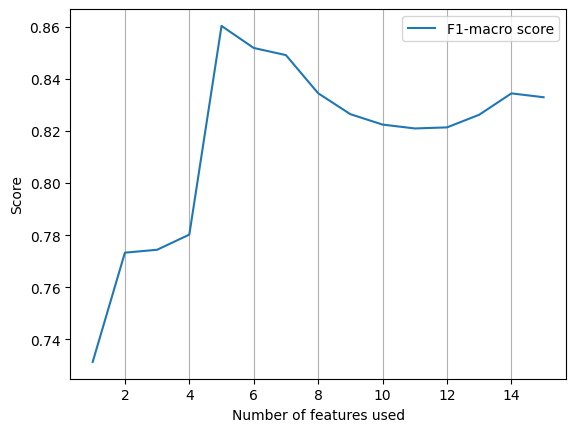

---------------------------------------------------------
Test set ROC curve result


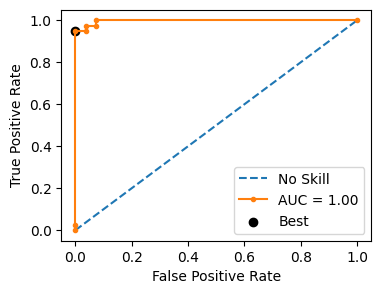

Best Threshold=0.801347, G-Mean=0.974
-------------------------------------------
Test set Precision-recall curve result


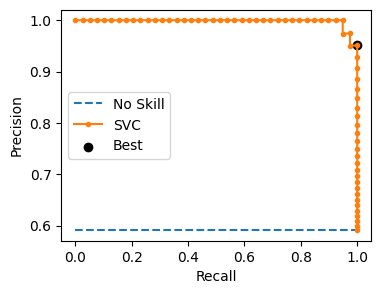

Best Threshold=0.402518, F-Score=0.975
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        27
         1.0       0.97      0.97      0.97        39

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66

[[26  1]
 [ 1 38]]
There are 2 misclassification from 66 voice files.
---------------------------------------------------------


In [62]:
l1_1 = l1_feature_selection(test_label_5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df_test_5,y_df_test_5,x_df1.shape[1],param_grid2,'l1norm_rbf_1')

In [63]:
l1norm_recall.append(l1_1[7])
l1norm_f1.append(l1_1[8])
l1_sel_feat_list.append(l1_1[9])

In [64]:
cms1 = check_mistake_subjects(l1_1,'L1_1')
cms1

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_05_1,0,5,0.0
PD_10_1,0,5,0.0
PD_14_1,0,4,0.0
PD_17_1,1,15,6.667
PD_20_1,0,5,0.0
PD_21_1,0,5,0.0
Control_05_1,0,4,0.0
Control_10_1,0,4,0.0
Control_12_1,1,5,20.0


In [65]:
df_all_feature_count = df_all_feature_count.append(l1_1[0])
df_best_val_score_l1 = df_best_val_score_l1.append(l1_1[3])
df_best_c_l1 = df_best_c_l1.append(l1_1[4])
df_best_gamma_l1 = df_best_gamma_l1.append(l1_1[5])

/tmp/ipykernel_31435/4105150763.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(l1_1[0])
/tmp/ipykernel_31435/4105150763.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_l1 = df_best_val_score_l1.append(l1_1[3])
/tmp/ipykernel_31435/4105150763.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_l1 = df_best_c_l1.append(l1_1[4])
/tmp/ipykernel_31435/4105150763.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_l1 = df_best_gamma_l1.append(l1_1[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.0, 'SVC__gamma': 0.62} with f1-macro score at 0.7371151372259868
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 8.858667904100825, 'SVC__gamma': 0.02} with f1-macro score at 0.7889441136471129
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'RPDE', 'DFA'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 48.32930238571752, 'SVC__gamma': 0.04} with f1-macro score at 0.802337358954732
-------------------------------

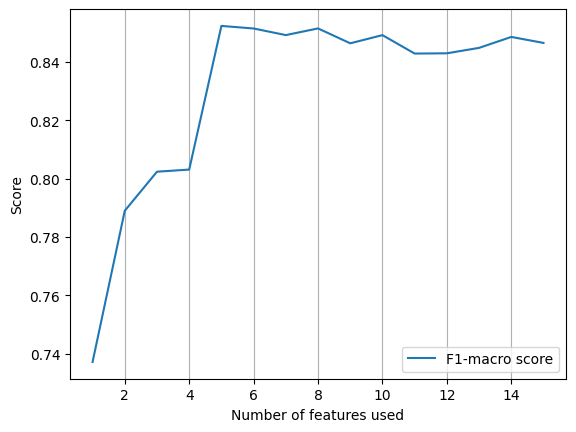

---------------------------------------------------------
Test set ROC curve result


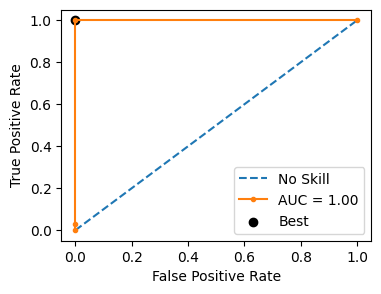

Best Threshold=0.650349, G-Mean=1.000
-------------------------------------------
Test set Precision-recall curve result


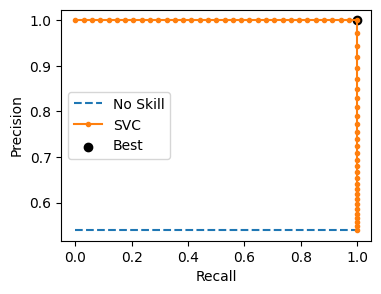

Best Threshold=0.650349, F-Score=1.000
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        29
         1.0       0.97      1.00      0.99        34

    accuracy                           0.98        63
   macro avg       0.99      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63

[[28  1]
 [ 0 34]]
There are 1 misclassification from 63 voice files.
---------------------------------------------------------


In [66]:
l1_2 = l1_feature_selection(test_label_1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df5,y_df5,x_df_test_1,y_df_test_1,x_df1.shape[1],param_grid2,'l1norm_rbf_2')

In [67]:
l1norm_recall.append(l1_2[7])
l1norm_f1.append(l1_2[8])
l1_sel_feat_list.append(l1_2[9])

In [68]:
cms2 = check_mistake_subjects(l1_2,'L1_2')
cms2

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_01_1,0,5,0.0
PD_06_1,0,10,0.0
PD_14_1,0,4,0.0
PD_19_1,0,5,0.0
PD_20_1,0,5,0.0
PD_25_1,0,5,0.0
Control_01_1,0,5,0.0
Control_06_1,0,5,0.0
Control_11_1,0,5,0.0


In [69]:
df_all_feature_count = df_all_feature_count.append(l1_2[0])
df_best_val_score_l1 = df_best_val_score_l1.append(l1_2[3])
df_best_c_l1 = df_best_c_l1.append(l1_2[4])
df_best_gamma_l1 = df_best_gamma_l1.append(l1_2[5])

/tmp/ipykernel_31435/3377991118.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(l1_2[0])
/tmp/ipykernel_31435/3377991118.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_l1 = df_best_val_score_l1.append(l1_2[3])
/tmp/ipykernel_31435/3377991118.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_l1 = df_best_c_l1.append(l1_2[4])
/tmp/ipykernel_31435/3377991118.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_l1 = df_best_gamma_l1.append(l1_2[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.0, 'SVC__gamma': 0.54} with f1-macro score at 0.7347659540802399
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 48.32930238571752, 'SVC__gamma': 0.02} with f1-macro score at 0.7723879781104843
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'RPDE', 'DFA'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 100.0, 'SVC__gamma': 0.02} with f1-macro score at 0.7966992097259876
------------------------------------------

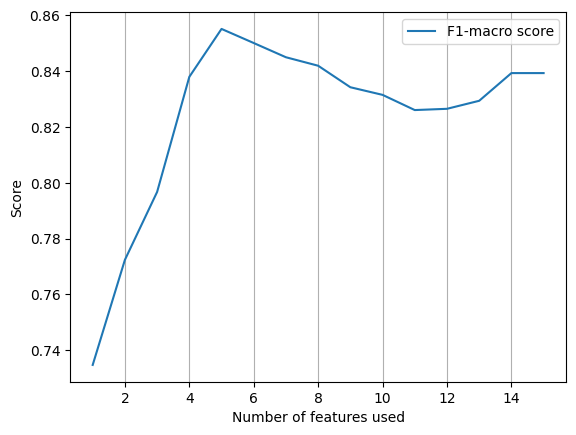

---------------------------------------------------------
Test set ROC curve result


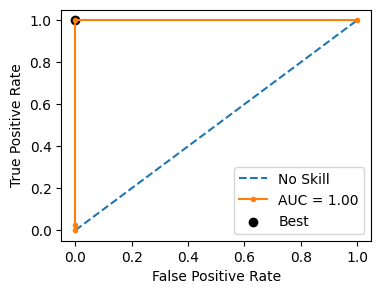

Best Threshold=0.658782, G-Mean=1.000
-------------------------------------------
Test set Precision-recall curve result


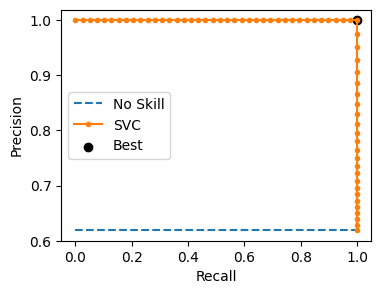

Best Threshold=0.658782, F-Score=1.000
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00        39

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

[[24  0]
 [ 0 39]]
There are 0 misclassification from 63 voice files.
---------------------------------------------------------


In [70]:
l1_3 = l1_feature_selection(test_label_2,x_df3,y_df3,x_df4,y_df4,x_df5,y_df5,x_df1,y_df1,x_df_test_2,y_df_test_2,x_df1.shape[1],param_grid2,'l1norm_rbf_3')

In [71]:
l1norm_recall.append(l1_3[7])
l1norm_f1.append(l1_3[8])
l1_sel_feat_list.append(l1_3[9])

In [72]:
cms3 = check_mistake_subjects(l1_3,'L1_3')
cms3

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_02_1,0,5,0.0
PD_07_1,0,5,0.0
PD_11_1,0,10,0.0
PD_14_1,0,4,0.0
PD_18_1,0,5,0.0
PD_20_1,0,5,0.0
PD_23_1,0,5,0.0
Control_02_1,0,5,0.0
Control_07_1,0,5,0.0


In [73]:
df_all_feature_count = df_all_feature_count.append(l1_3[0])
df_best_val_score_l1 = df_best_val_score_l1.append(l1_3[3])
df_best_c_l1 = df_best_c_l1.append(l1_3[4])
df_best_gamma_l1 = df_best_gamma_l1.append(l1_3[5])

/tmp/ipykernel_31435/1776253590.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(l1_3[0])
/tmp/ipykernel_31435/1776253590.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_l1 = df_best_val_score_l1.append(l1_3[3])
/tmp/ipykernel_31435/1776253590.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_l1 = df_best_c_l1.append(l1_3[4])
/tmp/ipykernel_31435/1776253590.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_l1 = df_best_gamma_l1.append(l1_3[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.6237767391887217, 'SVC__gamma': 0.060000000000000005} with f1-macro score at 0.76312632547187
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 37.926901907322495, 'SVC__gamma': 0.02} with f1-macro score at 0.80526052061207
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'RPDE', 'DFA'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 6.951927961775605, 'SVC__gamma': 0.05} with f1-macro score at 0.8145304947914354
--

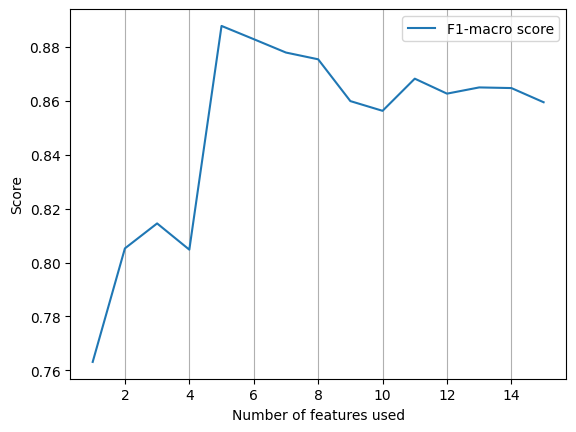

---------------------------------------------------------
Test set ROC curve result


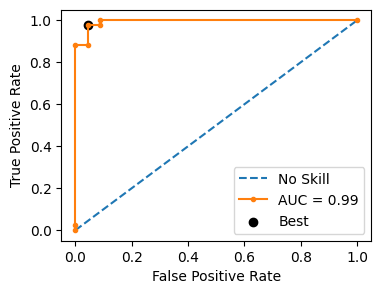

Best Threshold=0.204077, G-Mean=0.967
-------------------------------------------
Test set Precision-recall curve result


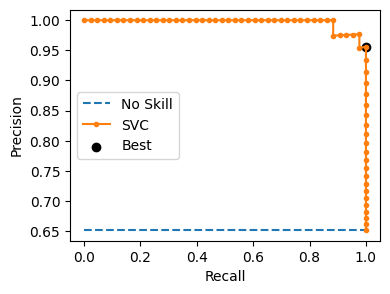

Best Threshold=0.168927, F-Score=0.977
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        23
         1.0       1.00      0.88      0.94        43

    accuracy                           0.92        66
   macro avg       0.91      0.94      0.92        66
weighted avg       0.94      0.92      0.93        66

[[23  0]
 [ 5 38]]
There are 5 misclassification from 66 voice files.
---------------------------------------------------------


In [74]:
l1_4 = l1_feature_selection(test_label_3,x_df4,y_df4,x_df5,y_df5,x_df1,y_df1,x_df2,y_df2,x_df_test_3,y_df_test_3,x_df1.shape[1],param_grid2,'l1norm_rbf_4')

In [75]:
l1norm_recall.append(l1_4[7])
l1norm_f1.append(l1_4[8])
l1_sel_feat_list.append(l1_4[9])

In [76]:
cms4 = check_mistake_subjects(l1_4,'L1_4')
cms4

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_03_1,1,5,20.0
PD_08_1,0,10,0.0
PD_12_1,0,5,0.0
PD_14_1,0,4,0.0
PD_15_1,0,4,0.0
PD_20_1,0,5,0.0
PD_24_1,4,10,40.0
Control_04_1,0,4,0.0
Control_08_1,0,5,0.0


In [77]:
df_all_feature_count = df_all_feature_count.append(l1_4[0])
df_best_val_score_l1 = df_best_val_score_l1.append(l1_4[3])
df_best_c_l1 = df_best_c_l1.append(l1_4[4])
df_best_gamma_l1 = df_best_gamma_l1.append(l1_4[5])

/tmp/ipykernel_31435/3013378333.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(l1_4[0])
/tmp/ipykernel_31435/3013378333.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_l1 = df_best_val_score_l1.append(l1_4[3])
/tmp/ipykernel_31435/3013378333.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_l1 = df_best_c_l1.append(l1_4[4])
/tmp/ipykernel_31435/3013378333.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_l1 = df_best_gamma_l1.append(l1_4[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 3.3598182862837818, 'SVC__gamma': 1.0} with f1-macro score at 0.7505398613986406
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 14.38449888287663, 'SVC__gamma': 0.02} with f1-macro score at 0.790843825267388
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['HNR', 'localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 48.32930238571752, 'SVC__gamma': 0.01} with f1-macro score at 0.7837996658999928
-----------------

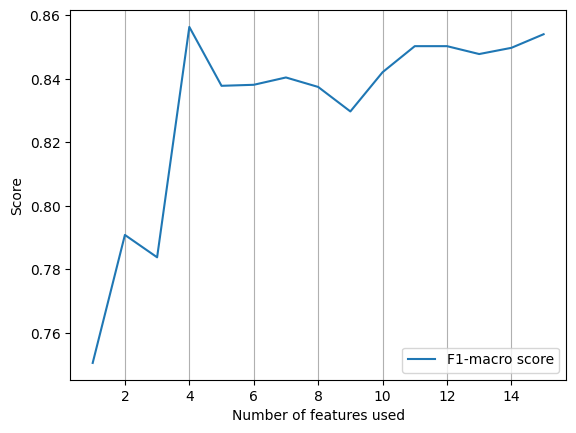

---------------------------------------------------------
Test set ROC curve result


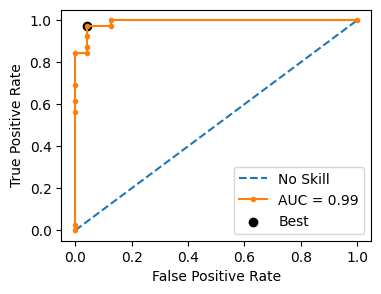

Best Threshold=0.685303, G-Mean=0.966
-------------------------------------------
Test set Precision-recall curve result


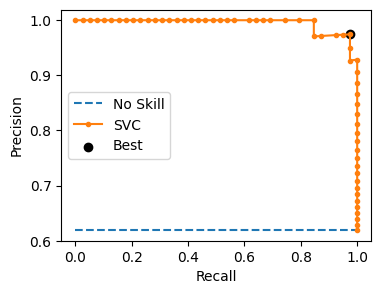

Best Threshold=0.685303, F-Score=0.974
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88        24
         1.0       0.89      1.00      0.94        39

    accuracy                           0.92        63
   macro avg       0.94      0.90      0.91        63
weighted avg       0.93      0.92      0.92        63

[[19  5]
 [ 0 39]]
There are 5 misclassification from 63 voice files.
---------------------------------------------------------


In [78]:
l1_5 = l1_feature_selection(test_label_4,x_df5,y_df5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df_test_4,y_df_test_4,x_df1.shape[1],param_grid2,'l1norm_rbf_5')

In [79]:
l1norm_recall.append(l1_5[7])
l1norm_f1.append(l1_5[8])
l1_sel_feat_list.append(l1_5[9])

In [80]:
cms5 = check_mistake_subjects(l1_5,'L1_5')
cms5

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_04_1,0,5,0.0
PD_09_1,0,5,0.0
PD_13_1,0,10,0.0
PD_14_1,0,4,0.0
PD_16_1,0,5,0.0
PD_20_1,0,5,0.0
PD_22_1,0,5,0.0
Control_03_1,2,5,40.0
Control_09_1,0,5,0.0


In [81]:
df_all_feature_count = df_all_feature_count.append(l1_5[0])
df_best_val_score_l1 = df_best_val_score_l1.append(l1_5[3])
df_best_c_l1 = df_best_c_l1.append(l1_5[4])
df_best_gamma_l1 = df_best_gamma_l1.append(l1_5[5])

/tmp/ipykernel_31435/2311975434.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(l1_5[0])
/tmp/ipykernel_31435/2311975434.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_l1 = df_best_val_score_l1.append(l1_5[3])
/tmp/ipykernel_31435/2311975434.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_l1 = df_best_c_l1.append(l1_5[4])
/tmp/ipykernel_31435/2311975434.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_l1 = df_best_gamma_l1.append(l1_5[5])


In [82]:
def f1_allplot(x1,y1,label1,x2,y2,label2,x3,y3,label3,x4,y4,label4,x5,y5,label5):
  plt.plot(x1,y1, label = label1)
  plt.plot(x2,y2, label = label2)
  plt.plot(x3,y3, label = label3)
  plt.plot(x4,y4, label = label4)
  plt.plot(x5,y5, label = label5)
  plt.title('F1-macro score in each iteration of feature selection process')
  plt.xlabel('Number of features used')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.grid(axis = 'x')
  plt.show()

x_range = np.linspace(1,x_df1.shape[1],x_df1.shape[1],endpoint =True,dtype=int)

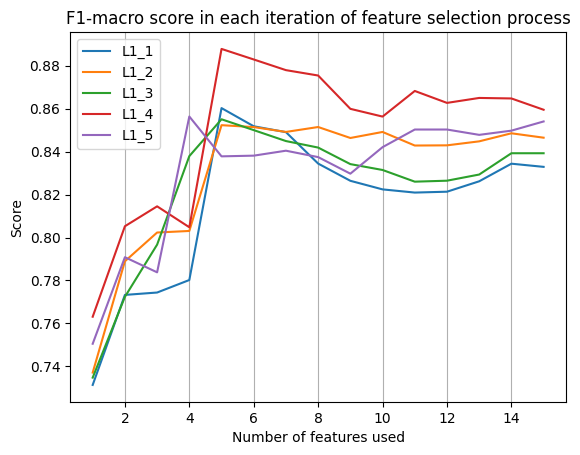

In [83]:
f1_allplot(
    x_range, l1_1[6],'L1_1',
    x_range, l1_2[6], 'L1_2',
    x_range, l1_3[6],'L1_3',
    x_range, l1_4[6],'L1_4',
    x_range, l1_5[6],'L1_5'    
)

Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 29.76351441631318, 'SVC__gamma': 0.53} with f1-macro score at 0.7313717328095717
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 37.926901907322495, 'SVC__gamma': 0.01} with f1-macro score at 0.7732879720269493
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'ddaShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 29.76351441631318, 'SVC__gamma': 0.01} with f1-macro score at 0.7706369869208338
--------

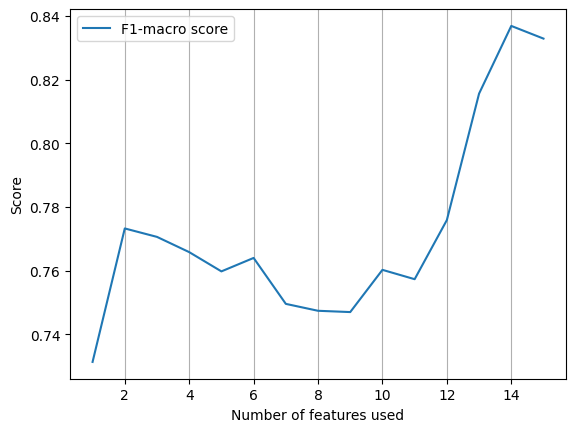

---------------------------------------------------------
Test set ROC curve result


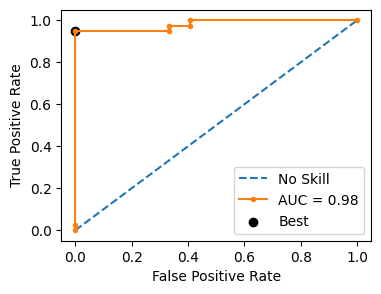

Best Threshold=0.373680, G-Mean=0.974
-------------------------------------------
Test set Precision-recall curve result


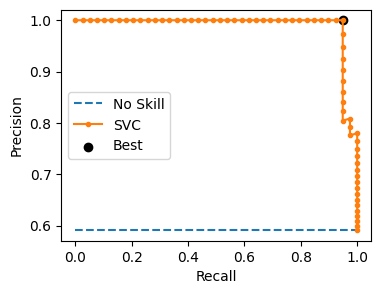

Best Threshold=0.373680, F-Score=0.974
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        27
         1.0       1.00      0.92      0.96        39

    accuracy                           0.95        66
   macro avg       0.95      0.96      0.95        66
weighted avg       0.96      0.95      0.95        66

[[27  0]
 [ 3 36]]
There are 3 misclassification from 66 voice files.
---------------------------------------------------------


In [84]:
rfe_1 = rfe(test_label_5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df_test_5,y_df_test_5,x_df1.shape[1],param_grid2,'rfe_1')

In [85]:
rfe_recall.append(rfe_1[7])
rfe_f1.append(rfe_1[8])
rfe_sel_feat_list.append(rfe_1[9])

In [86]:
cms1_r = check_mistake_subjects(rfe_1,'rfe_1')
cms1_r

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_05_1,0,5,0.0
PD_10_1,0,5,0.0
PD_14_1,2,4,50.0
PD_17_1,1,15,6.667
PD_20_1,0,5,0.0
PD_21_1,0,5,0.0
Control_05_1,0,4,0.0
Control_10_1,0,4,0.0
Control_12_1,0,5,0.0


In [87]:
def cms_summary(l1,rfe,name):
    df = pd.concat([l1,rfe],axis=1)
    df.columns = pd.MultiIndex.from_tuples(
    zip(['','L1_norm','','','RFE',''],
       df.columns)
    )
    df.to_csv(f'{name}.csv')
    return df

In [88]:
cms_summary(cms1,cms1_r,'09102023_final_reports/Classifying mistakes summary #1')

L1_norm                        \
             Incorrect Samples Total Samples Misclassification (%)   
Name                                                                 
PD_05_1                      0             5                   0.0   
PD_10_1                      0             5                   0.0   
PD_14_1                      0             4                   0.0   
PD_17_1                      1            15                 6.667   
PD_20_1                      0             5                   0.0   
PD_21_1                      0             5                   0.0   
Control_05_1                 0             4                   0.0   
Control_10_1                 0             4                   0.0   
Control_12_1                 1             5                  20.0   
Control_16_1                 0             5                   0.0   
Control_21_1                 0             5                   0.0   
Control_24_1                 0             4                   0.0   

                                         RFE                        
             Incorrect Samples Total Samples Misclassification (%)  
Name                                                                
PD_05_1                      0             5                   0.0  
PD_10_1                      0             5                   0.0  
PD_14_1                      2             4                  50.0  
PD_17_1                      1            15                 6.667  
PD_20_1                      0             5                   0.0  
PD_21_1                      0             5                   0.0  
Control_05_1                 0             4                   0.0  
Control_10_1                 0             4                   0.0  
Control_12_1                 0             5                   0.0  
Control_16_1                 0             5                   0.0  
Control_21_1                 0             5                   0.0  
Control_24_1                 0             4                   0.0

In [89]:
df_all_feature_count = df_all_feature_count.append(rfe_1[0])
df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_1[3])
df_best_c_rfe = df_best_c_rfe.append(rfe_1[4])
df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_1[5])

/tmp/ipykernel_31435/2421599628.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(rfe_1[0])
/tmp/ipykernel_31435/2421599628.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_1[3])
/tmp/ipykernel_31435/2421599628.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_rfe = df_best_c_rfe.append(rfe_1[4])
/tmp/ipykernel_31435/2421599628.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_1[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.0, 'SVC__gamma': 0.62} with f1-macro score at 0.7371151372259868
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 8.858667904100825, 'SVC__gamma': 0.02} with f1-macro score at 0.7889441136471129
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'ddaShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 6.951927961775605, 'SVC__gamma': 0.01} with f1-macro score at 0.7855340880688801
-----------------------

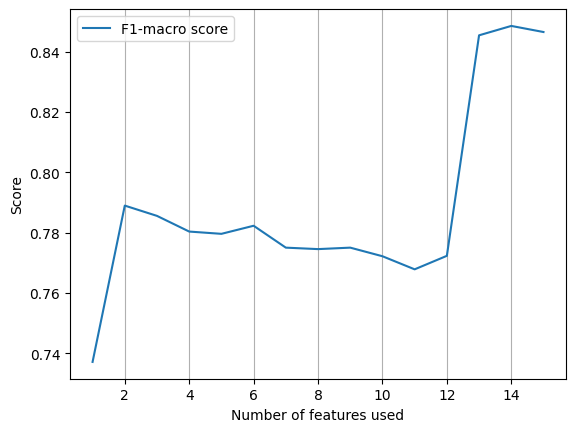

---------------------------------------------------------
Test set ROC curve result


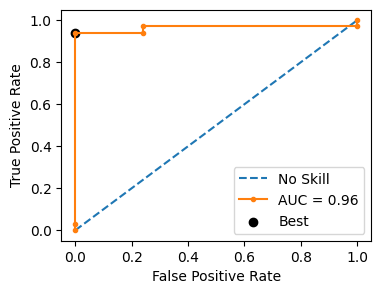

Best Threshold=0.429519, G-Mean=0.970
-------------------------------------------
Test set Precision-recall curve result


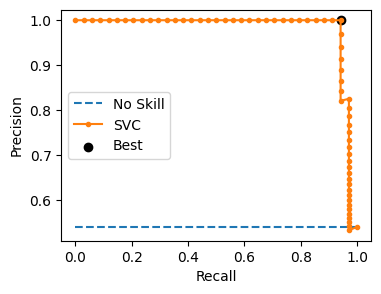

Best Threshold=0.429519, F-Score=0.970
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        29
         1.0       1.00      0.88      0.94        34

    accuracy                           0.94        63
   macro avg       0.94      0.94      0.94        63
weighted avg       0.94      0.94      0.94        63

[[29  0]
 [ 4 30]]
There are 4 misclassification from 63 voice files.
---------------------------------------------------------


In [90]:
rfe_2 = rfe(test_label_1,x_df2,y_df2,x_df3,y_df3,x_df4,y_df4,x_df5,y_df5,x_df_test_1,y_df_test_1,x_df1.shape[1],param_grid2,'rfe_2')

In [91]:
rfe_recall.append(rfe_2[7])
rfe_f1.append(rfe_2[8])
rfe_sel_feat_list.append(rfe_2[9])

In [92]:
cms2_r = check_mistake_subjects(rfe_2,'rfe_2')
cms2_r

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_01_1,0,5,0.0
PD_06_1,2,10,20.0
PD_14_1,2,4,50.0
PD_19_1,0,5,0.0
PD_20_1,0,5,0.0
PD_25_1,0,5,0.0
Control_01_1,0,5,0.0
Control_06_1,0,5,0.0
Control_11_1,0,5,0.0


In [93]:
cms_summary(cms2,cms2_r,'09102023_final_reports/Classifying mistakes summary #2')

L1_norm                        \
             Incorrect Samples Total Samples Misclassification (%)   
Name                                                                 
PD_01_1                      0             5                   0.0   
PD_06_1                      0            10                   0.0   
PD_14_1                      0             4                   0.0   
PD_19_1                      0             5                   0.0   
PD_20_1                      0             5                   0.0   
PD_25_1                      0             5                   0.0   
Control_01_1                 0             5                   0.0   
Control_06_1                 0             5                   0.0   
Control_11_1                 0             5                   0.0   
Control_15_1                 1             5                  20.0   
Control_20_1                 0             5                   0.0   
Control_24_1                 0             4                   0.0   

                                         RFE                        
             Incorrect Samples Total Samples Misclassification (%)  
Name                                                                
PD_01_1                      0             5                   0.0  
PD_06_1                      2            10                  20.0  
PD_14_1                      2             4                  50.0  
PD_19_1                      0             5                   0.0  
PD_20_1                      0             5                   0.0  
PD_25_1                      0             5                   0.0  
Control_01_1                 0             5                   0.0  
Control_06_1                 0             5                   0.0  
Control_11_1                 0             5                   0.0  
Control_15_1                 0             5                   0.0  
Control_20_1                 0             5                   0.0  
Control_24_1                 0             4                   0.0

In [94]:
df_all_feature_count = df_all_feature_count.append(rfe_2[0])
df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_2[3])
df_best_c_rfe = df_best_c_rfe.append(rfe_2[4])
df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_2[5])

/tmp/ipykernel_31435/1689142212.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(rfe_2[0])
/tmp/ipykernel_31435/1689142212.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_2[3])
/tmp/ipykernel_31435/1689142212.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_rfe = df_best_c_rfe.append(rfe_2[4])
/tmp/ipykernel_31435/1689142212.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_2[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.0, 'SVC__gamma': 0.54} with f1-macro score at 0.7347659540802399
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 48.32930238571752, 'SVC__gamma': 0.02} with f1-macro score at 0.7723879781104843
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'ddaShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.0, 'SVC__gamma': 0.04} with f1-macro score at 0.7663583094829081
-------------------------------------

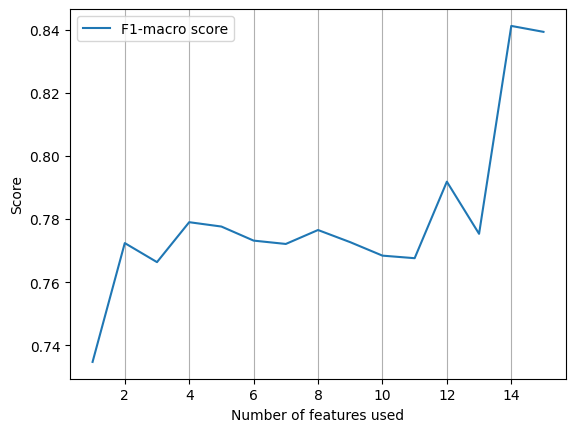

---------------------------------------------------------
Test set ROC curve result


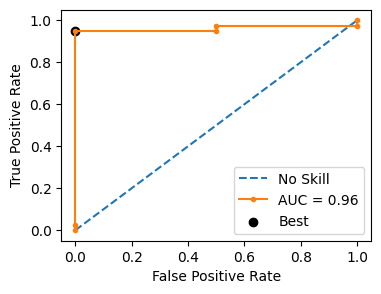

Best Threshold=0.400601, G-Mean=0.974
-------------------------------------------
Test set Precision-recall curve result


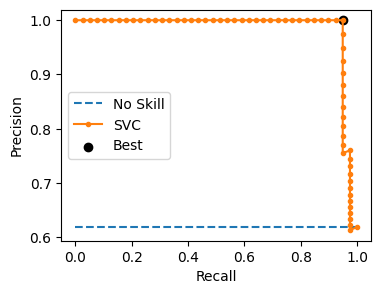

Best Threshold=0.400601, F-Score=0.974
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        24
         1.0       1.00      0.92      0.96        39

    accuracy                           0.95        63
   macro avg       0.94      0.96      0.95        63
weighted avg       0.96      0.95      0.95        63

[[24  0]
 [ 3 36]]
There are 3 misclassification from 63 voice files.
---------------------------------------------------------


In [95]:
rfe_3 = rfe(test_label_2,x_df3,y_df3,x_df4,y_df4,x_df5,y_df5,x_df1,y_df1,x_df_test_2,y_df_test_2,x_df1.shape[1],param_grid2,'rfe_3')

In [96]:
rfe_recall.append(rfe_3[7])
rfe_f1.append(rfe_3[8])
rfe_sel_feat_list.append(rfe_3[9])

In [97]:
cms3_r = check_mistake_subjects(rfe_3,'rfe_3')
cms3_r

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_02_1,0,5,0.0
PD_07_1,1,5,20.0
PD_11_1,0,10,0.0
PD_14_1,2,4,50.0
PD_18_1,0,5,0.0
PD_20_1,0,5,0.0
PD_23_1,0,5,0.0
Control_02_1,0,5,0.0
Control_07_1,0,5,0.0


In [98]:
cms_summary(cms3,cms3_r,'09102023_final_reports/Classifying mistakes summary #3')

L1_norm                        \
             Incorrect Samples Total Samples Misclassification (%)   
Name                                                                 
PD_02_1                      0             5                   0.0   
PD_07_1                      0             5                   0.0   
PD_11_1                      0            10                   0.0   
PD_14_1                      0             4                   0.0   
PD_18_1                      0             5                   0.0   
PD_20_1                      0             5                   0.0   
PD_23_1                      0             5                   0.0   
Control_02_1                 0             5                   0.0   
Control_07_1                 0             5                   0.0   
Control_13_1                 0             5                   0.0   
Control_19_1                 0             5                   0.0   
Control_24_1                 0             4                   0.0   

                                         RFE                        
             Incorrect Samples Total Samples Misclassification (%)  
Name                                                                
PD_02_1                      0             5                   0.0  
PD_07_1                      1             5                  20.0  
PD_11_1                      0            10                   0.0  
PD_14_1                      2             4                  50.0  
PD_18_1                      0             5                   0.0  
PD_20_1                      0             5                   0.0  
PD_23_1                      0             5                   0.0  
Control_02_1                 0             5                   0.0  
Control_07_1                 0             5                   0.0  
Control_13_1                 0             5                   0.0  
Control_19_1                 0             5                   0.0  
Control_24_1                 0             4                   0.0

In [99]:
df_all_feature_count = df_all_feature_count.append(rfe_3[0])
df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_3[3])
df_best_c_rfe = df_best_c_rfe.append(rfe_3[4])
df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_3[5])

/tmp/ipykernel_31435/1005511367.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(rfe_3[0])
/tmp/ipykernel_31435/1005511367.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_3[3])
/tmp/ipykernel_31435/1005511367.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_rfe = df_best_c_rfe.append(rfe_3[4])
/tmp/ipykernel_31435/1005511367.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_3[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 1.6237767391887217, 'SVC__gamma': 0.060000000000000005} with f1-macro score at 0.76312632547187
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 37.926901907322495, 'SVC__gamma': 0.02} with f1-macro score at 0.80526052061207
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'ddaShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 3.3598182862837818, 'SVC__gamma': 0.06999999999999999} with f1-macro score a

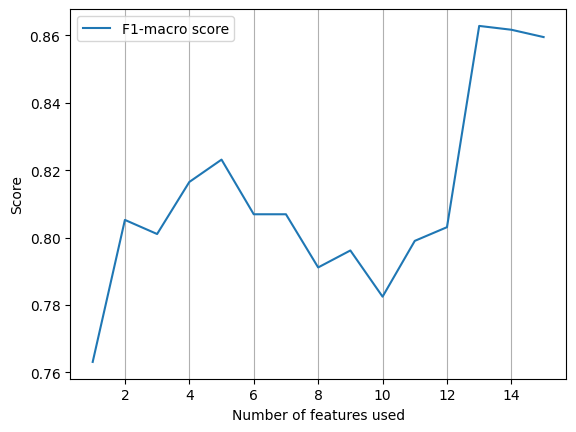

---------------------------------------------------------
Test set ROC curve result


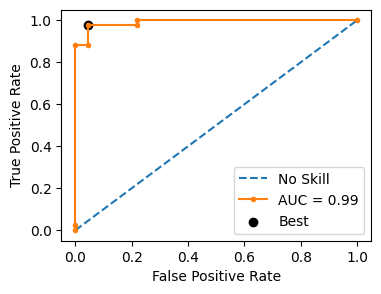

Best Threshold=0.156948, G-Mean=0.967
-------------------------------------------
Test set Precision-recall curve result


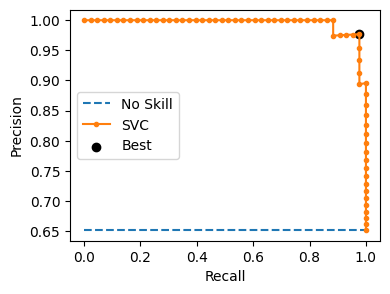

Best Threshold=0.156948, F-Score=0.977
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82        23
         1.0       1.00      0.77      0.87        43

    accuracy                           0.85        66
   macro avg       0.85      0.88      0.84        66
weighted avg       0.89      0.85      0.85        66

[[23  0]
 [10 33]]
There are 10 misclassification from 66 voice files.
---------------------------------------------------------


In [100]:
rfe_4 = rfe(test_label_3,x_df4,y_df4,x_df5,y_df5,x_df1,y_df1,x_df2,y_df2,x_df_test_3,y_df_test_3,x_df1.shape[1],param_grid2,'rfe_4')

In [101]:
rfe_recall.append(rfe_4[7])
rfe_f1.append(rfe_4[8])
rfe_sel_feat_list.append(rfe_4[9])

In [102]:
cms4_r = check_mistake_subjects(rfe_4,'rfe_4')
cms4_r

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_03_1,2,5,40.0
PD_08_1,0,10,0.0
PD_12_1,0,5,0.0
PD_14_1,2,4,50.0
PD_15_1,0,4,0.0
PD_20_1,0,5,0.0
PD_24_1,6,10,60.0
Control_04_1,0,4,0.0
Control_08_1,0,5,0.0


In [103]:
cms_summary(cms4,cms4_r,'09102023_final_reports/Classifying mistakes summary #4')

L1_norm                        \
             Incorrect Samples Total Samples Misclassification (%)   
Name                                                                 
PD_03_1                      1             5                  20.0   
PD_08_1                      0            10                   0.0   
PD_12_1                      0             5                   0.0   
PD_14_1                      0             4                   0.0   
PD_15_1                      0             4                   0.0   
PD_20_1                      0             5                   0.0   
PD_24_1                      4            10                  40.0   
Control_04_1                 0             4                   0.0   
Control_08_1                 0             5                   0.0   
Control_18_1                 0             5                   0.0   
Control_23_1                 0             5                   0.0   
Control_24_1                 0             4                   0.0   

                                         RFE                        
             Incorrect Samples Total Samples Misclassification (%)  
Name                                                                
PD_03_1                      2             5                  40.0  
PD_08_1                      0            10                   0.0  
PD_12_1                      0             5                   0.0  
PD_14_1                      2             4                  50.0  
PD_15_1                      0             4                   0.0  
PD_20_1                      0             5                   0.0  
PD_24_1                      6            10                  60.0  
Control_04_1                 0             4                   0.0  
Control_08_1                 0             5                   0.0  
Control_18_1                 0             5                   0.0  
Control_23_1                 0             5                   0.0  
Control_24_1                 0             4                   0.0

In [104]:
df_all_feature_count = df_all_feature_count.append(rfe_4[0])
df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_4[3])
df_best_c_rfe = df_best_c_rfe.append(rfe_4[4])
df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_4[5])

/tmp/ipykernel_31435/1131807347.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(rfe_4[0])
/tmp/ipykernel_31435/1131807347.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_4[3])
/tmp/ipykernel_31435/1131807347.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_rfe = df_best_c_rfe.append(rfe_4[4])
/tmp/ipykernel_31435/1131807347.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_4[5])


Results when using 1 features
Selected features are Index(['RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 3.3598182862837818, 'SVC__gamma': 1.0} with f1-macro score at 0.7505398613986406
-------------------------------------------------------------------------- 
Results when using 2 features
Selected features are Index(['localdbShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 14.38449888287663, 'SVC__gamma': 0.02} with f1-macro score at 0.790843825267388
-------------------------------------------------------------------------- 
Results when using 3 features
Selected features are Index(['localdbShimmer', 'ddaShimmer', 'RPDE'], dtype='object').
Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
 
The parameters are {'SVC__C': 5.455594781168519, 'SVC__gamma': 0.02} with f1-macro score at 0.8094383141549492
----------

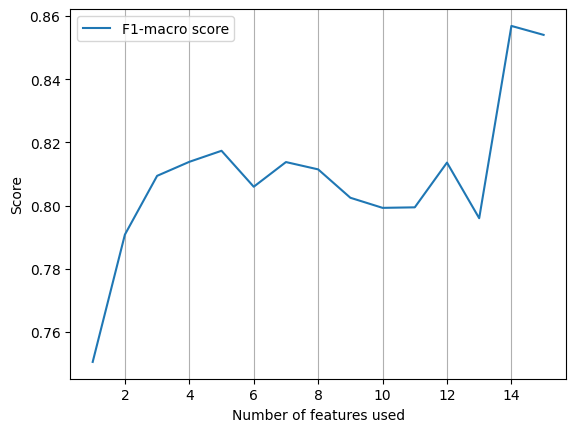

---------------------------------------------------------
Test set ROC curve result


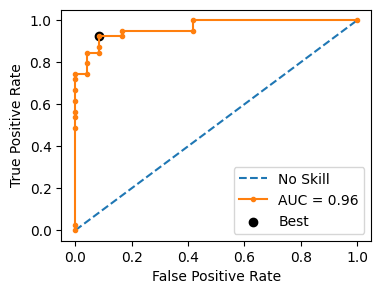

Best Threshold=0.773118, G-Mean=0.920
-------------------------------------------
Test set Precision-recall curve result


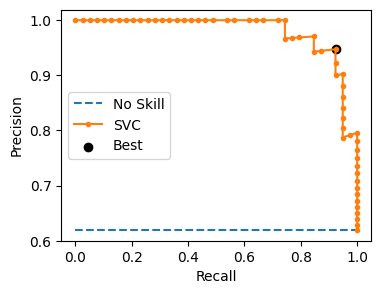

Best Threshold=0.773118, F-Score=0.935
-------------------------------------------
Test report
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82        24
         1.0       0.86      0.95      0.90        39

    accuracy                           0.87        63
   macro avg       0.88      0.85      0.86        63
weighted avg       0.88      0.87      0.87        63

[[18  6]
 [ 2 37]]
There are 8 misclassification from 63 voice files.
---------------------------------------------------------


In [105]:
rfe_5 = rfe(test_label_4,x_df5,y_df5,x_df1,y_df1,x_df2,y_df2,x_df3,y_df3,x_df_test_4,y_df_test_4,x_df1.shape[1],param_grid2,'rfe_5')

In [106]:
rfe_recall.append(rfe_5[7])
rfe_f1.append(rfe_5[8])
rfe_sel_feat_list.append(rfe_5[9])

In [107]:
cms5_r = check_mistake_subjects(rfe_5,'rfe_5')
cms5_r

,Incorrect Samples,Total Samples,Misclassification (%)
Name,,,
PD_04_1,0,5,0.0
PD_09_1,0,5,0.0
PD_13_1,0,10,0.0
PD_14_1,2,4,50.0
PD_16_1,0,5,0.0
PD_20_1,0,5,0.0
PD_22_1,0,5,0.0
Control_03_1,3,5,60.0
Control_09_1,0,5,0.0


In [108]:
cms_summary(cms5,cms5_r,'09102023_final_reports/Classifying mistakes summary #5')

L1_norm                        \
             Incorrect Samples Total Samples Misclassification (%)   
Name                                                                 
PD_04_1                      0             5                   0.0   
PD_09_1                      0             5                   0.0   
PD_13_1                      0            10                   0.0   
PD_14_1                      0             4                   0.0   
PD_16_1                      0             5                   0.0   
PD_20_1                      0             5                   0.0   
PD_22_1                      0             5                   0.0   
Control_03_1                 2             5                  40.0   
Control_09_1                 0             5                   0.0   
Control_17_1                 2             5                  40.0   
Control_22_1                 1             5                  20.0   
Control_24_1                 0             4                   0.0   

                                         RFE                        
             Incorrect Samples Total Samples Misclassification (%)  
Name                                                                
PD_04_1                      0             5                   0.0  
PD_09_1                      0             5                   0.0  
PD_13_1                      0            10                   0.0  
PD_14_1                      2             4                  50.0  
PD_16_1                      0             5                   0.0  
PD_20_1                      0             5                   0.0  
PD_22_1                      0             5                   0.0  
Control_03_1                 3             5                  60.0  
Control_09_1                 0             5                   0.0  
Control_17_1                 1             5                  20.0  
Control_22_1                 2             5                  40.0  
Control_24_1                 0             4                   0.0

In [109]:
df_all_feature_count = df_all_feature_count.append(rfe_5[0])
df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_5[3])
df_best_c_rfe = df_best_c_rfe.append(rfe_5[4])
df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_5[5])

/tmp/ipykernel_31435/1357741311.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_feature_count = df_all_feature_count.append(rfe_5[0])
/tmp/ipykernel_31435/1357741311.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_val_score_rfe = df_best_val_score_rfe.append(rfe_5[3])
/tmp/ipykernel_31435/1357741311.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_c_rfe = df_best_c_rfe.append(rfe_5[4])
/tmp/ipykernel_31435/1357741311.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_best_gamma_rfe = df_best_gamma_rfe.append(rfe_5[5])


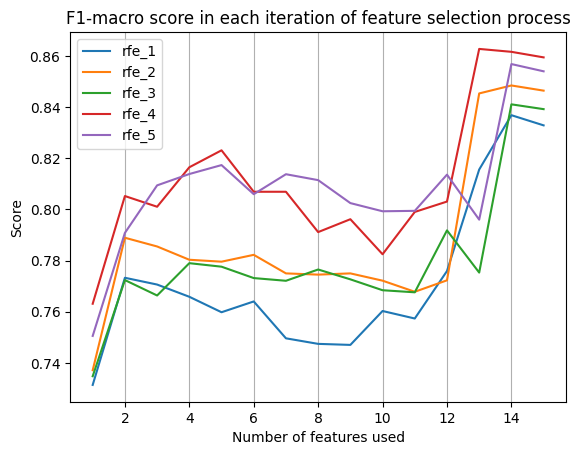

In [110]:
f1_allplot(
    x_range, rfe_1[6],'rfe_1',
    x_range, rfe_2[6], 'rfe_2',
    x_range, rfe_3[6],'rfe_3',
    x_range, rfe_4[6],'rfe_4',
    x_range, rfe_5[6],'rfe_5'    
)

In [111]:
df_all_feature_count

,RPDE,localdbShimmer,DFA,HNR,meanF0Hz,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer
l1norm_rbf_1,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
l1norm_rbf_2,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
l1norm_rbf_3,15,14,13,11,12,10,9,8,7,6,5,4,3,2,1
l1norm_rbf_4,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1
l1norm_rbf_5,15,14,1,13,12,11,10,9,8,7,6,5,4,3,2
rfe_1,15,14,4,2,3,9,1,6,5,12,11,10,7,8,13
rfe_2,15,14,4,2,3,10,1,7,6,12,11,9,5,8,13
rfe_3,15,14,4,3,2,10,1,7,6,12,11,9,5,8,13
rfe_4,15,14,4,1,3,10,2,7,8,12,11,9,6,5,13
rfe_5,15,14,4,3,2,9,1,6,7,12,11,10,8,5,13


In [112]:
df_best_val_score_l1

,1 feature,2 features,3 features,4 features,5 features,6 features,7 features,8 features,9 features,10 features,11 features,12 features,13 features,14 features,15 features
l1norm_rbf_1,0.731372,0.773288,0.774396,0.780220,0.860271,0.851810,0.849072,0.834439,0.826419,0.822422,0.820940,0.821343,0.826189,0.834390,0.832910
l1norm_rbf_2,0.737115,0.788944,0.802337,0.803065,0.852320,0.851439,0.849176,0.851465,0.846359,0.849165,0.842845,0.842932,0.844792,0.848545,0.846494
l1norm_rbf_3,0.734766,0.772388,0.796699,0.837912,0.855071,0.850019,0.844927,0.841891,0.834189,0.831458,0.826018,0.826467,0.829338,0.839256,0.839256
l1norm_rbf_4,0.763126,0.805261,0.814530,0.804791,0.887830,0.882918,0.877949,0.875444,0.859930,0.856320,0.868254,0.862697,0.865005,0.864766,0.859506
l1norm_rbf_5,0.750540,0.790844,0.783800,0.856354,0.837808,0.838130,0.840436,0.837454,0.829736,0.842088,0.850297,0.850297,0.847814,0.849770,0.854055


In [113]:
df_best_val_score_rfe

,1 feature,2 features,3 features,4 features,5 features,6 features,7 features,8 features,9 features,10 features,11 features,12 features,13 features,14 features,15 features
rfe_1,0.731372,0.773288,0.770637,0.765853,0.759805,0.764027,0.749602,0.747432,0.747027,0.760286,0.757351,0.775919,0.815627,0.836891,0.832910
rfe_2,0.737115,0.788944,0.785534,0.780337,0.779582,0.782261,0.775005,0.774518,0.775005,0.772154,0.767813,0.772292,0.845401,0.848516,0.846494
rfe_3,0.734766,0.772388,0.766358,0.779000,0.777623,0.773171,0.772111,0.776523,0.772672,0.768414,0.767603,0.791830,0.775320,0.841133,0.839256
rfe_4,0.763126,0.805261,0.801075,0.816516,0.823149,0.806935,0.806935,0.791159,0.796193,0.782491,0.799040,0.803104,0.862815,0.861678,0.859506
rfe_5,0.750540,0.790844,0.809438,0.813876,0.817371,0.805989,0.813801,0.811484,0.802502,0.799305,0.799468,0.813632,0.796024,0.856892,0.854055


In [114]:
dataset_col = ['Algorithm','Dataset 1','Dataset 2','Dataset 3','Dataset 4','Dataset 5']

In [115]:
df_recall = pd.DataFrame(data = [l1norm_recall, rfe_recall],
                        columns = dataset_col).set_index(['Algorithm'])

In [116]:
df_f1 = pd.DataFrame(data = [l1norm_f1, rfe_f1],
                    columns = dataset_col).set_index(['Algorithm'])

In [117]:
df_recall['mean'] = df_recall.mean(axis=1)
df_recall = df_recall.style.highlight_max(color = 'pink',axis =0)
df_recall.to_excel('09102023_final_reports/recall.xlsx')
df_recall

,Dataset 1,Dataset 2,Dataset 3,Dataset 4,Dataset 5,mean
Algorithm,,,,,,
L1_norm_recall,0.974359,1.000000,1.000000,0.883721,1.000000,0.971616
RFE_recall,0.923077,0.882353,0.923077,0.767442,0.948718,0.888933


In [118]:
df_f1['mean'] = df_f1.mean(axis=1)
df_f1 = df_f1.style.highlight_max(color = 'lightblue',axis =0)
df_f1.to_excel('09102023_final_reports/f1.xlsx')
df_f1

,Dataset 1,Dataset 2,Dataset 3,Dataset 4,Dataset 5,mean
Algorithm,,,,,,
L1_norm_f1,0.968661,0.983982,1.000000,0.920116,0.911740,0.956900
RFE_f1,0.953684,0.936492,0.950588,0.844925,0.860310,0.909200


In [119]:
from collections import Counter

In [120]:
def sel_feat_count(sel_feat_list):
    counter_list = []
    for i in sel_feat_list:
        counter_list.append(Counter(i))
        
    return sum(counter_list, Counter())

def sel_feat_count_df(l1,rfe):
    l1_count = sel_feat_count(l1_sel_feat_list)
    rfe_count = sel_feat_count(rfe_sel_feat_list)
    one = pd.DataFrame.from_dict(l1_count, columns = ['l1_count'], orient='index').transpose()
    two = pd.DataFrame.from_dict(rfe_count,columns = ['rfe_count'], orient='index').transpose()
    one = one.append(two).fillna(int(0))
    one.to_csv('09102023_final_reports/selected_feature_count.csv')
    return one

In [121]:
sel_feat_count_df(l1_sel_feat_list, rfe_sel_feat_list)

/tmp/ipykernel_31435/1392425569.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one = one.append(two).fillna(int(0))


,meanF0Hz,HNR,localdbShimmer,RPDE,DFA,localJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer
l1_count,5,5,5,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rfe_count,5,4,5,5,5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [122]:
df_best_val_score_l1 = df_best_val_score_l1.style.highlight_max(color = 'pink',axis =1)
df_best_val_score_rfe = df_best_val_score_rfe.style.highlight_max(color = 'pink',axis =1)

In [123]:
df_best_val_score_l1

,1 feature,2 features,3 features,4 features,5 features,6 features,7 features,8 features,9 features,10 features,11 features,12 features,13 features,14 features,15 features
l1norm_rbf_1,0.731372,0.773288,0.774396,0.780220,0.860271,0.851810,0.849072,0.834439,0.826419,0.822422,0.820940,0.821343,0.826189,0.834390,0.832910
l1norm_rbf_2,0.737115,0.788944,0.802337,0.803065,0.852320,0.851439,0.849176,0.851465,0.846359,0.849165,0.842845,0.842932,0.844792,0.848545,0.846494
l1norm_rbf_3,0.734766,0.772388,0.796699,0.837912,0.855071,0.850019,0.844927,0.841891,0.834189,0.831458,0.826018,0.826467,0.829338,0.839256,0.839256
l1norm_rbf_4,0.763126,0.805261,0.814530,0.804791,0.887830,0.882918,0.877949,0.875444,0.859930,0.856320,0.868254,0.862697,0.865005,0.864766,0.859506
l1norm_rbf_5,0.750540,0.790844,0.783800,0.856354,0.837808,0.838130,0.840436,0.837454,0.829736,0.842088,0.850297,0.850297,0.847814,0.849770,0.854055


In [124]:
df_best_val_score_rfe

,1 feature,2 features,3 features,4 features,5 features,6 features,7 features,8 features,9 features,10 features,11 features,12 features,13 features,14 features,15 features
rfe_1,0.731372,0.773288,0.770637,0.765853,0.759805,0.764027,0.749602,0.747432,0.747027,0.760286,0.757351,0.775919,0.815627,0.836891,0.832910
rfe_2,0.737115,0.788944,0.785534,0.780337,0.779582,0.782261,0.775005,0.774518,0.775005,0.772154,0.767813,0.772292,0.845401,0.848516,0.846494
rfe_3,0.734766,0.772388,0.766358,0.779000,0.777623,0.773171,0.772111,0.776523,0.772672,0.768414,0.767603,0.791830,0.775320,0.841133,0.839256
rfe_4,0.763126,0.805261,0.801075,0.816516,0.823149,0.806935,0.806935,0.791159,0.796193,0.782491,0.799040,0.803104,0.862815,0.861678,0.859506
rfe_5,0.750540,0.790844,0.809438,0.813876,0.817371,0.805989,0.813801,0.811484,0.802502,0.799305,0.799468,0.813632,0.796024,0.856892,0.854055


In [125]:
df_best_val_score_l1.to_excel('09102023_final_reports/best_score_l1.xlsx')
df_best_val_score_rfe.to_excel('09102023_final_reports/best_score_rfe.xlsx')

df_best_c_l1.to_csv('09102023_final_reports/best_c_l1.csv')
df_best_c_rfe.to_csv('09102023_final_reports/best_c_rfe.csv')

df_best_gamma_l1.to_csv('09102023_final_reports/best_gamma_l1.csv')
df_best_gamma_rfe.to_csv('09102023_final_reports/best_gamma_rfe.csv')

In [126]:
df_all_feature_count = df_all_feature_count.transpose()
df_all_feature_count['average'] =df_all_feature_count.mean(axis=0)
df_all_feature_count = df_all_feature_count.sort_values(by = ['average'],ascending=False)
df_all_feature_count

,l1norm_rbf_1,l1norm_rbf_2,l1norm_rbf_3,l1norm_rbf_4,l1norm_rbf_5,rfe_1,rfe_2,rfe_3,rfe_4,rfe_5,average
RPDE,15,15,15,15,15,15,15,15,15,15,NaN
localdbShimmer,14,14,14,14,14,14,14,14,14,14,NaN
DFA,13,13,13,13,1,4,4,4,4,4,NaN
HNR,12,12,11,12,13,2,2,3,1,3,NaN
meanF0Hz,11,11,12,11,12,3,3,2,3,2,NaN
localJitter,10,10,10,10,11,9,10,10,10,9,NaN
localabsoluteJitter,9,9,9,9,10,1,1,1,2,1,NaN
rapJitter,8,8,8,8,9,6,7,7,7,6,NaN
ppq5Jitter,7,7,7,7,8,5,6,6,8,7,NaN
ddpJitter,6,6,6,6,7,12,12,12,12,12,NaN


In [127]:
feat_count_l1 = df_all_feature_count[['l1norm_rbf_1','l1norm_rbf_2','l1norm_rbf_3','l1norm_rbf_4', 'l1norm_rbf_5']]
feat_count_l1['avg'] = feat_count_l1.mean(axis=1)
feat_count_l1 = feat_count_l1.sort_values(by = ['avg'],ascending=False)
feat_count_l1

/tmp/ipykernel_31435/3135422881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_count_l1['avg'] = feat_count_l1.mean(axis=1)


,l1norm_rbf_1,l1norm_rbf_2,l1norm_rbf_3,l1norm_rbf_4,l1norm_rbf_5,avg
RPDE,15,15,15,15,15,15.0
localdbShimmer,14,14,14,14,14,14.0
HNR,12,12,11,12,13,12.0
meanF0Hz,11,11,12,11,12,11.4
DFA,13,13,13,13,1,10.6
localJitter,10,10,10,10,11,10.2
localabsoluteJitter,9,9,9,9,10,9.2
rapJitter,8,8,8,8,9,8.2
ppq5Jitter,7,7,7,7,8,7.2
ddpJitter,6,6,6,6,7,6.2


In [128]:
feat_count_rfe = df_all_feature_count[['rfe_1','rfe_2','rfe_3','rfe_4', 'rfe_5']]
feat_count_rfe['avg'] = feat_count_rfe.mean(axis=1)
feat_count_rfe = feat_count_rfe.sort_values(by = ['avg'],ascending=False)
feat_count_rfe

/tmp/ipykernel_31435/211298813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_count_rfe['avg'] = feat_count_rfe.mean(axis=1)


,rfe_1,rfe_2,rfe_3,rfe_4,rfe_5,avg
RPDE,15,15,15,15,15,15.0
localdbShimmer,14,14,14,14,14,14.0
ddaShimmer,13,13,13,13,13,13.0
ddpJitter,12,12,12,12,12,12.0
localShimmer,11,11,11,11,11,11.0
localJitter,9,10,10,10,9,9.6
apq3Shimmer,10,9,9,9,10,9.4
apq11Shimmer,8,8,8,5,5,6.8
rapJitter,6,7,7,7,6,6.6
ppq5Jitter,5,6,6,8,7,6.4


In [129]:
feat_count_l1.to_csv('09102023_final_reports/features_count_l1.csv')
feat_count_rfe.to_csv('09102023_final_reports/features_count_rfe.csv')